# Instruction !!!!!!!

Before running the simulation, please install "prim" library. We strongly suggest not to run the experiments since it will take to run the whole code. We advise to run the scipts with a file of our results of experiments to save time. To do this, please run all cell below the "perform experiments" that have "read" function inside.

Since all the script from the section 4 need the code from section 1 to 3 please run section 1 to three to perform the script for section 4 onwards

In [ ]:
# !pip install prim

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from  ema_workbench.analysis  import parcoords

from dike_model_function import *

from problem_formulation_ver_4 import *

from ema_workbench import Policy, perform_experiments, Scenario, Constraint, ema_logging, MultiprocessingEvaluator
from ema_workbench import ema_logging
from ema_workbench import MultiprocessingEvaluator

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, sample_uncertainties
from ema_workbench.analysis.scenario_discovery_util import CLASSIFICATION, REGRESSION
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

from analysis import *
from ema_workbench.analysis import prim, dimensional_stacking

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
import statsmodels.api as sm
import prim as prm
ema_logging.log_to_stderr(ema_logging.INFO)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<Logger EMA (DEBUG)>

## Random Seed
    
    Since we forgot to set and check the seed before the experiments, it might produce results whhich slightly different that we have in the report. Nevertheless, this is how we would define the seed before we run.

In [784]:
# import random

# random.setstate(old_state)
# print( random.random())

0.14951712406852946


# 1. Dike Model Function 

In [2]:
dike_model = get_model_for_problem_formulation()

[MainProcess/INFO] model initialized


## 1.1 Random Open Exploration

In [4]:
n_scenarios = 500
n_policies = 100

start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_randomize = evaluator.perform_experiments(n_scenarios, n_policies)
    
end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 100 policies * 1 model(s) = 50000 experiments
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 15000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 25000 cases completed
[MainProcess/INFO] 30000 cases completed
[MainProcess/INFO] 35000 cases completed
[MainProcess/INFO] 40000 cases completed
[MainProcess/INFO] 45000 cases completed
[MainProcess/INFO] 50000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Processing time : 92.1107288479805 Minutes


In [5]:
experiments_randomize, outcomes_randomize = results_randomize

dfexperiment_randomize = pd.DataFrame(data=experiments_randomize)
dfoutput_randomize = pd.DataFrame(data=outcomes_randomize)
dfcombined_randomize = pd.concat([dfexperiment_randomize, dfoutput_randomize], axis=1)

dfexperiment_randomize.to_csv('dfexperiment_randomize.csv', encoding='utf-8', index=False)
dfoutput_randomize.to_csv('dfoutput_randomize.csv', encoding='utf-8', index=False)

## 1.2 Read Random Open Exploration and Visualize the Sensitivity and Distribution

In [517]:
df_experiment_randomize = pd.read_csv('dfexperiment_randomize.csv')
df_output_randomize = pd.read_csv('dfoutput_randomize.csv')

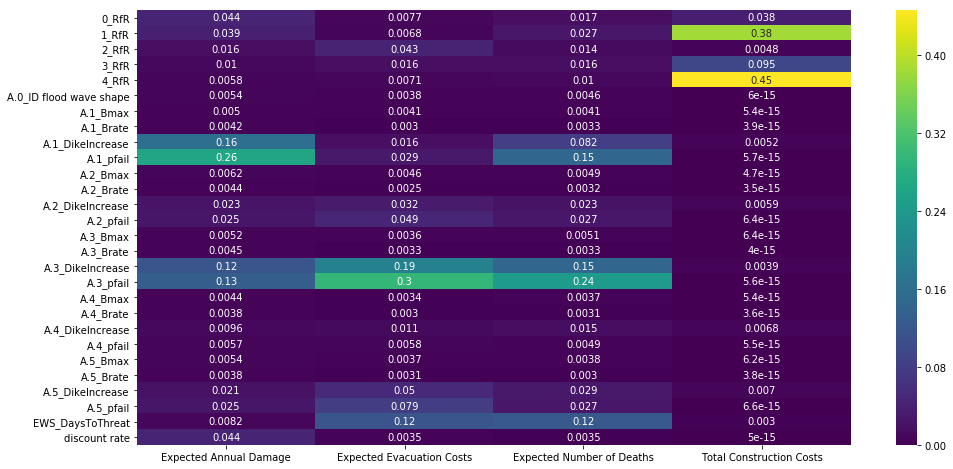

In [7]:
from ema_workbench.analysis import feature_scoring

# all input except the levers (uncertainties)
x_f = df_experiment_randomize.drop(['scenario_id','policy','model'],axis=1).to_records(index=False)

# all output of experiment
outcomex = ((df_output_randomize).to_dict('list'))

scores = feature_scoring.get_feature_scores_all(x_f, outcomex)
plt.figure(figsize = (16,8))
sns.heatmap(scores,annot=True,cmap='viridis')
plt.show()

In [579]:
print('Average distribution')

print(
list(dike_model.outcomes.keys())[0],' : ',df_output_randomize[list(dike_model.outcomes.keys())[0]].mean(),'\n',
list(dike_model.outcomes.keys())[1],' : ',df_output_randomize[list(dike_model.outcomes.keys())[1]].mean(),'\n',
list(dike_model.outcomes.keys())[2],' : ',df_output_randomize[list(dike_model.outcomes.keys())[2]].mean(),'\n',
list(dike_model.outcomes.keys())[3],' : ',df_output_randomize[list(dike_model.outcomes.keys())[3]].mean())

Average distribution
Expected Number of Deaths  :  0.033129323113438275 
 Expected Evacuation Costs  :  3115.228182243156 
 Expected Annual Damage  :  88103883.02545771 
 Total Construction Costs  :  508915742.6177583


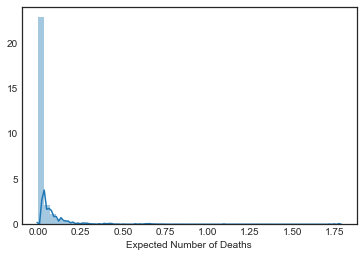

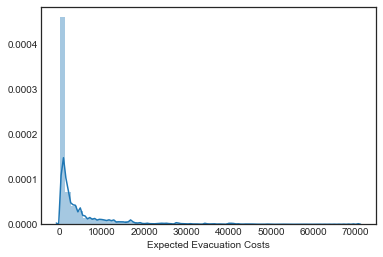

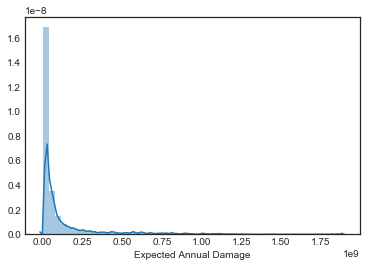

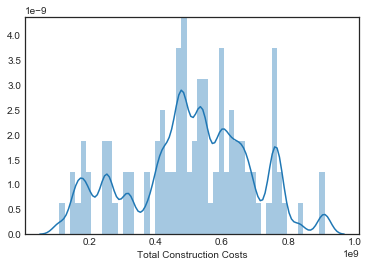

In [808]:
sns.distplot(df_output_randomize['Expected Number of Deaths'])
plt.show()
sns.distplot(df_output_randomize['Expected Evacuation Costs'])
plt.show()
sns.distplot(df_output_randomize['Expected Annual Damage'])
plt.show()
sns.distplot(df_output_randomize['Total Construction Costs'])
plt.show()

# 2. Policy and Scenario Function

In [809]:
def scenario_parameter (Bmax_1 = 30, Bmax_2 = 30,Bmax_3 = 30,Bmax_4 = 30,Bmax_5 = 30,
                        pfail_1 = 0, pfail_2 = 0, pfail_3 = 0, pfail_4 = 0, pfail_5 = 0, 
                        Brate_1 = 0, Brate_2 = 0, Brate_3 = 0, Brate_4 = 0, Brate_5 = 0, 
                        discount_rate = 0, wave_shape = 0) :
    
    scenario_0 = {'A.1_Bmax': Bmax_1, 'A.1_pfail': pfail_1, 'A.1_Brate': Brate_1, 
                    'A.2_Bmax': Bmax_2, 'A.2_pfail': pfail_2, 'A.2_Brate': Brate_2, 
                    'A.3_Bmax': Bmax_3, 'A.3_pfail': pfail_3, 'A.3_Brate': Brate_3, 
                    'A.4_Bmax': Bmax_4, 'A.4_pfail': pfail_4, 'A.4_Brate': Brate_4, 
                    'A.5_Bmax': Bmax_5, 'A.5_pfail': pfail_5, 'A.5_Brate': Brate_5,
                    'discount rate': discount_rate,
                    'A.0_ID flood wave shape': wave_shape}
    return scenario_0

In [810]:
def levers_parameter (Dike_1 = 0, Dike_2 = 0,Dike_3 = 0,Dike_4 = 0,Dike_5 = 0, 
                      rfr_0 = 0, rfr_1 = 0, rfr_2 = 0, rfr_3 = 0, rfr_4 = 0,
                      EWS = 0) :
    
    levers_param = {'A.1_DikeIncrease': Dike_1, 'A.2_DikeIncrease': Dike_2, 'A.3_DikeIncrease': Dike_3, 
                  'A.4_DikeIncrease': Dike_4, 'A.5_DikeIncrease': Dike_5,
                  '0_RfR': rfr_0, '1_RfR': rfr_1, '2_RfR': rfr_2, '3_RfR': rfr_3, '4_RfR': rfr_4,
                  'EWS_DaysToThreat': EWS}
    
    return levers_param

In [815]:
# No Uncertainties
scenario_0 = Scenario("Scenario_0", **scenario_parameter())

dikes_scenario = scenario_parameter(175,175,175,175,175
                                    ,0.01575,0.05,0.00895,0.05,0.0456
                                    ,1.5,1.5,1.5,1.5,1.5
                                    ,2.5
                                    ,66)

catastrophy_scenario = scenario_parameter(318.25,332.5,332.5,332.5,332.5
                                    ,0.5,0.5,0.5,0.5,0.5
                                    ,1000,1000,1000,1000,1000
                                    ,2.5
                                    ,66)

percent_50_scenario = scenario_parameter(175,175,175,175,175
                                    ,0.5,0.5,0.5,0.5,0.5
                                    ,1.5,1.5,1.5,1.5,1.5
                                    ,2.5
                                    ,66)

percent_25_scenario = scenario_parameter(87.5,87.5,87.5,87.5,87.5
                                    ,0.75,0.75,0.75,0.75,0.75
                                    ,0.9,0.9,0.9,0.9,0.9
                                    ,1.5
                                    ,33)

dikes_scenario_ref = Scenario("Fragile_dikes", **dikes_scenario)
catastrophy_scenario_ref = Scenario("Catastrophy", **catastrophy_scenario)
percent_50_scenario_ref = Scenario("50_percent", **percent_50_scenario)
percent_25_scenario_ref = Scenario("25_percent", **percent_25_scenario)

# No Policies
policy_0 = Policy("No_Policy", **{l.name:0 for l in dike_model.levers})

# Policy with all Maximum mitigation on
policy_max = Policy("Policy_Max", **levers_parameter(10,10,10,10,10,1,1,1,1,1,4))

# 3. Directed Exploration with Reference Policy

## 3.1 SOBOL Directed Exploration

In [11]:
n_scenarios = 250

start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_sobol_0 = evaluator.perform_experiments(n_scenarios, [policy_0,policy_max], 
                                                    uncertainty_sampling= SOBOL, levers_sampling=SOBOL)
end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 18000 scenarios * 2 policies * 1 model(s) = 36000 experiments
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 21600 cases completed
[MainProcess/INFO] 25200 cases completed
[MainProcess/INFO] 28800 cases completed
[MainProcess/INFO] 32400 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Processing time : 66.06846226056417 Minutes


In [12]:
experiments_sobol_0, outcomes_sobol_0 = results_sobol_0

dfexperiment_sobol_0 = pd.DataFrame(data=experiments_sobol_0)
dfoutput_sobol_0 = pd.DataFrame(data=outcomes_sobol_0)
dfcombined_sobol_0 = pd.concat([dfexperiment_sobol_0, dfoutput_sobol_0], axis=1)

dfexperiment_sobol_0.to_csv('dfexperiment_sobol_0.csv', encoding='utf-8', index=False)
dfoutput_sobol_0.to_csv('dfoutput_sobol_0.csv', encoding='utf-8', index=False)

### 3.1.1 Read SOBOL experiment and predefine definition for visualization

In [7]:
df_experiment_sobol_0 = pd.read_csv('dfexperiment_sobol_0.csv')
df_output_sobol_0 = pd.read_csv('dfoutput_sobol_0.csv')

In [8]:
select_policy_0 = (df_experiment_sobol_0.policy == 'No_Policy')
select_policy_max = (df_experiment_sobol_0.policy == 'Policy_Max')

no_policy_0 = df_output_sobol_0[select_policy_0]['Expected Number of Deaths'].values
max_policy_0 = df_output_sobol_0[select_policy_max]['Expected Number of Deaths'].values

sobol_problem = problem = get_SALib_problem(dike_model.uncertainties)

##### Define function for SOBOL visualization

In [9]:
def plot_scores(scores,figsize=(12,8)):
    scores_filtered = {k:scores[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(figsize[0],figsize[1])
    fig.subplots_adjust(bottom=0.3)
    return fig

def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)
    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(ymax=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.ix[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})

### 3.1.2 No Policy SOBOL Visualization

In [16]:
a_scores = sobol.analyze(problem, no_policy_0, calc_second_order=True, print_to_console=False)
b_scores = sobol.analyze(problem, max_policy_0, calc_second_order=True, print_to_console=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


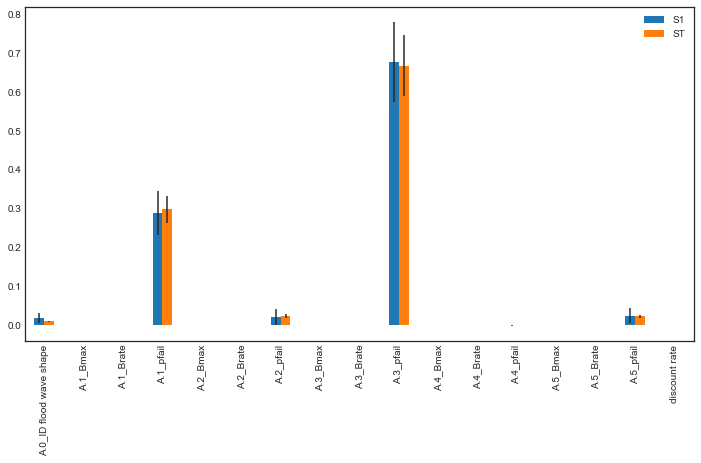

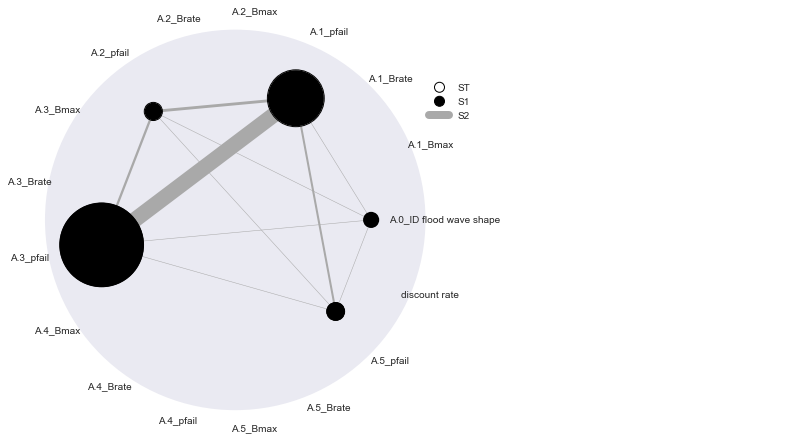

In [17]:
plot_scores(a_scores)

sns.set_style('darkgrid')
fig = plot_sobol_indices(a_scores, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)

plt.show()

### 3.1.3 Max Policy SOBOL Visualization

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


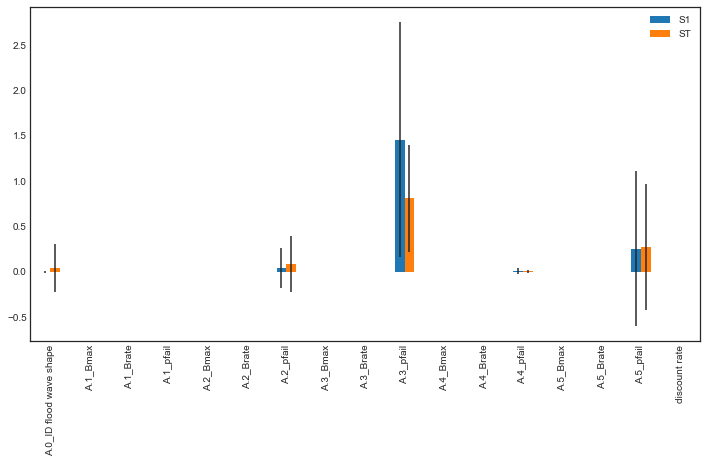

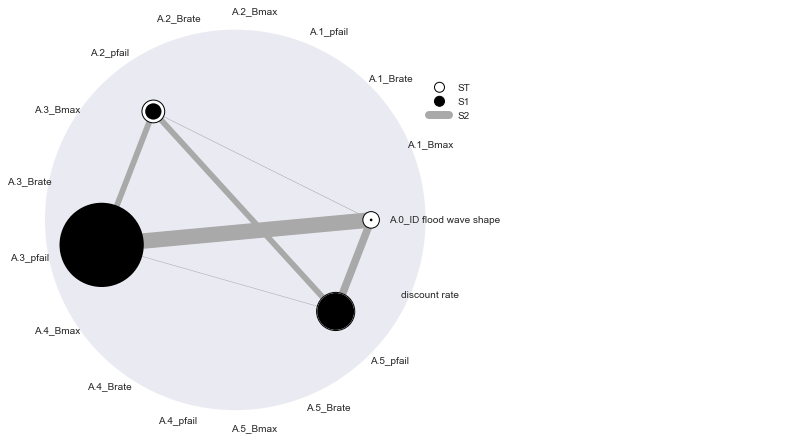

In [18]:
plot_scores(b_scores)

sns.set_style('darkgrid')
fig = plot_sobol_indices(b_scores, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)

plt.show()

### 3.2 PRIM Directed Exploration

In [19]:
n_scenarios = 10000

start = time.time()
with MultiprocessingEvaluator(dike_model) as evaluator:
    results_prim_0 = evaluator.perform_experiments(n_scenarios, [policy_0,policy_max])
    
end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10000 scenarios * 2 policies * 1 model(s) = 20000 experiments
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] 14000 cases completed
[MainProcess/INFO] 16000 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Processing time : 37.28549340963364 Minutes


In [20]:
experiments_prim_0, outcomes_prim_0 = results_prim_0

dfexperiment_prim_0 = pd.DataFrame(data=experiments_prim_0)
dfoutput_prim_0 = pd.DataFrame(data=outcomes_prim_0)
dfcombined_prim_0 = pd.concat([dfexperiment_prim_0, dfoutput_prim_0], axis=1)

dfexperiment_prim_0.to_csv('dfexperiment_prim_0.csv', encoding='utf-8', index=False)
dfoutput_prim_0.to_csv('dfoutput_prim_0.csv', encoding='utf-8', index=False)

### 3.2.1 Read LHS experiment and predefine definition for visualization

In [585]:
df_experiment_prim_0 = pd.read_csv('dfexperiment_prim_0.csv')
df_output_prim_0 = pd.read_csv('dfoutput_prim_0.csv')

In [586]:
select_policy_0 = (df_experiment_prim_0.policy == 'No_Policy')
select_policy_max = (df_experiment_prim_0.policy == 'Policy_Max')

### 3.2.2 No policy PRIM

In [587]:
# Select policy to do Prim
a_x_prim_0 = df_experiment_prim_0[select_policy_0].drop(['scenario_id','policy','model'],axis=1).to_records(index=False)
a_y_prim_0 = (df_output_prim_0[select_policy_0]['Expected Number of Deaths'] > 
              df_output_prim_0[select_policy_0]['Expected Number of Deaths'].quantile(.95)).astype(int).reset_index(drop=True)

In [588]:
prim_alg_0 = prm.Prim(a_x_prim_0, a_y_prim_0, threshold=0.8 ,threshold_type=">")
box1_0 = prim_alg_0.find_box()

<IPython.core.display.Javascript object>


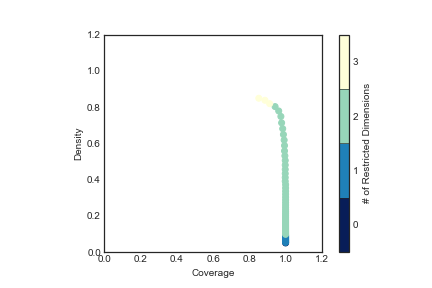

In [589]:
# %matplotlib inline
%matplotlib notebook
box1_0.show_tradeoff()
plt.show()

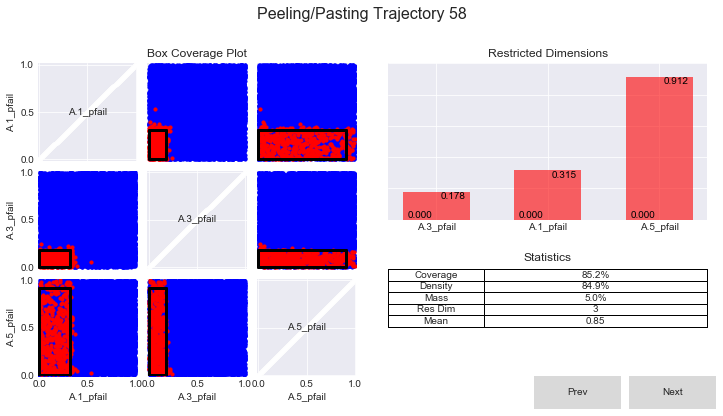

In [203]:
# box_selection = 58
# box1_0.select(box_selection)
box1_0.show_details()
plt.show()

### 3.2.3 Max policy PRIM

In [819]:
b_x_prim_0 = df_experiment_prim_0[select_policy_max].drop(['scenario_id','policy','model'],axis=1).to_records(index=False)
b_y_prim_0 = (df_output_prim_0[select_policy_max]['Expected Number of Deaths'] > 0).astype(int).reset_index(drop=True)

In [820]:
prim_alg_max = prm.Prim(b_x_prim_0, b_y_prim_0, threshold=0.8 ,threshold_type=">")
box1_max = prim_alg_max.find_box()

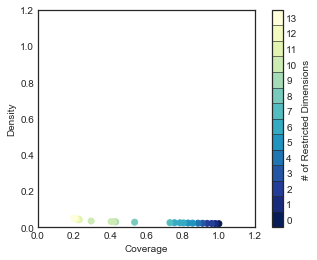

In [821]:
%matplotlib inline
box1_max.show_tradeoff()
plt.show()

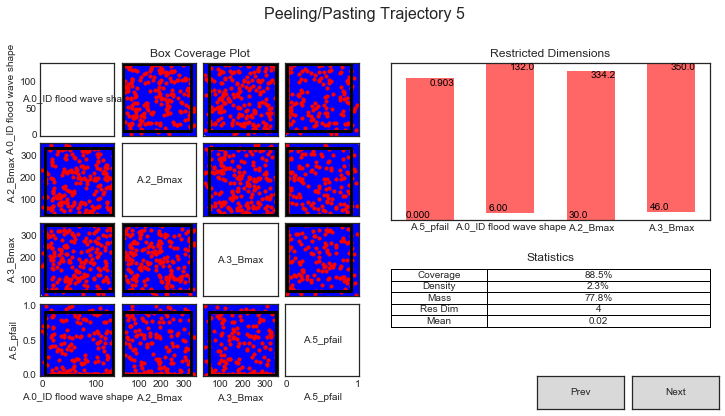

In [822]:
# %matplotlib notebook

box_selection = 5
box1_max.select(box_selection)
box1_max.show_details()
# plt.figure(figsize = (20,8))
plt.show()

### 3.2.4 PRIM for comparing zero policy with maximum policy according to objective "All costs"

In [814]:
len(df_output_prim_0[select_policy_0][df_output_prim_0[select_policy_0]['Expected Annual Damage'] > 
(df_output_prim_0[select_policy_max]['Total Construction Costs']).max()])

2791

It was proven by the code above, that there is exist scenario where "Zero Policy" Damage might exceed "maximum policy" costs, therefore it is necessary to look for the scenario in which these things happen

In [265]:
c_x_prim_0 = df_experiment_prim_0[select_policy_0].drop(['scenario_id','policy','model'],axis=1).to_records(index=False)
c_y_prim_0 = (df_output_prim_0[select_policy_0]['Expected Annual Damage'] > 
              (df_output_prim_0[select_policy_max]['Total Construction Costs']).max()).astype(int).reset_index(drop=True)

In [266]:
prim_alg_c = prm.Prim(c_x_prim_0, c_y_prim_0, threshold=0.8)
box1_c = prim_alg_c.find_box()

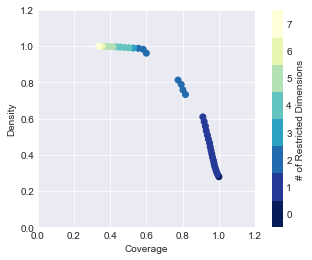

In [267]:
box1_c.show_tradeoff()
plt.show()

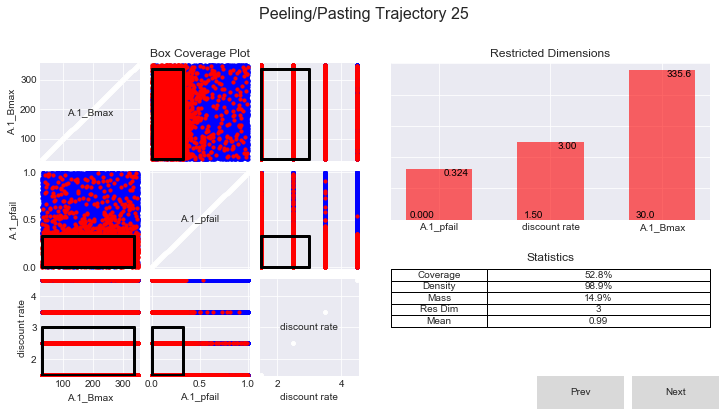

In [270]:
box_selection = 25
box1_c.select(box_selection)
box1_c.show_details()
plt.show()

# 4. Optimization

## 4.1 Search over Uncertainties (Worst Case Scenario Discovery)

In [290]:
# change outcomes so direction is undesirable for the uncertainty
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE

for outcome in dike_model.outcomes:
    if outcome.kind == minimize:
        outcome.kind = maximize
    else:
        outcome.kind = minimize

In [292]:
obj_max = []
obj_min = []
for name in dike_model.outcomes.keys():
    obj_min.append(min(df_output_prim_0[select_policy_0][name].min(),df_output_prim_0[select_policy_max][name].min()))
    obj_max.append(max(df_output_prim_0[select_policy_0][name].max(),df_output_prim_0[select_policy_max][name].max()))

### 4.1.1 Search over worst case in No Policy

In [293]:
worst_min_threshold_1 = df_output_prim_0[select_policy_0]['Expected Number of Deaths'].quantile(.975)
worst_min_threshold_2 = df_output_prim_0[select_policy_0]['Expected Annual Damage'].quantile(.975)

In [294]:
# constraint of the optimization (not use yet)
const = [Constraint("Death", outcome_names="Expected Number of Deaths",
                         function=lambda x: max(0,worst_min_threshold_1-x)) 
        ,Constraint("Damage Costs", outcome_names="Expected Annual Damage",
                         function=lambda x: max(0,worst_min_threshold_2-x))
       ]

nfe = 10000

convergence_metrics = [
                       HyperVolume( 
                                    minimum=obj_min, 
                                    maximum=obj_max),
                       EpsilonProgress()
                      ]

espilon = [0.001,100,1e3,1e4]

In [295]:
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_uncer_opt_0, convergence_uncer_opt_0 = evaluator.optimize(nfe=nfe, searchover='uncertainties',
                                 epsilons=espilon, reference=policy_0, convergence=convergence_metrics,
                                             constraints=const
                                            )
    
results_uncer_opt_0.to_csv('results_uncer_opt_0_raw.csv', encoding='utf-8', index=False)
convergence_uncer_opt_0.to_csv('convergence_uncer_opt_0.csv', encoding='utf-8', index=False)

end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 300/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 29: 2900/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 30: 3000/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 31: 3100/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[

[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 57: 5700/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 58: 5800/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 59: 5900/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/

[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 85: 8500/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 86: 8600/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 87: 8700/10000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 88: 8800/10000 nfe


Processing time : 21.383940895398457 Minutes


In [297]:
results_uncer_opt_0_raw = pd.read_csv('results_uncer_opt_0_raw.csv')
df_convergence_uncer_opt_0 = pd.read_csv('convergence_uncer_opt_0.csv')

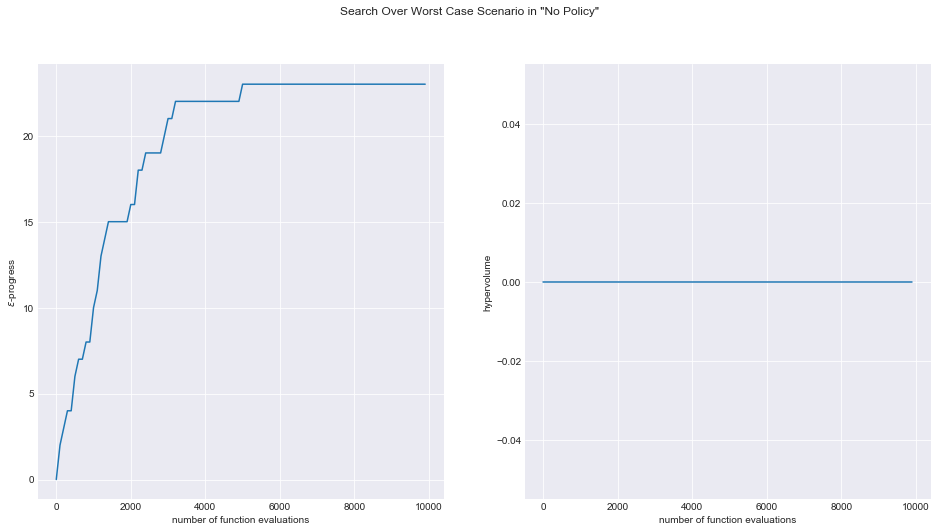

In [298]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(16,8))

ax1.plot(df_convergence_uncer_opt_0.nfe, df_convergence_uncer_opt_0.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(df_convergence_uncer_opt_0.nfe, df_convergence_uncer_opt_0.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.suptitle('Search Over Worst Case Scenario in "No Policy"')
plt.show()

In [299]:
a = results_uncer_opt_0.sort_values(by='Expected Number of Deaths',ascending=False)[(list(
    dike_model.uncertainties.keys()))].to_dict('records')

In [300]:
a[0]['A.1_Brate'] = a[0]['A.1_Brate'].value
a[0]['A.2_Brate'] = a[0]['A.2_Brate'].value
a[0]['A.3_Brate'] = a[0]['A.3_Brate'].value
a[0]['A.4_Brate'] = a[0]['A.4_Brate'].value
a[0]['A.5_Brate'] = a[0]['A.5_Brate'].value
a[0]['discount rate'] = a[0]['discount rate'].value

In [301]:
results_uncer_opt_0 = pd.DataFrame(a[0],index=[0])
results_uncer_opt_0.to_csv('results_uncer_opt_0.csv', encoding='utf-8', index=False)
df_results_uncer_opt_0 = pd.read_csv('results_uncer_opt_0.csv')

In [302]:
df_results_uncer_opt_0.to_dict('records')[0]

{'A.0_ID flood wave shape': 123.0,
 'A.1_Bmax': 62.969092474145825,
 'A.1_Brate': 0.90000000000000002,
 'A.1_pfail': 0.14457594156520301,
 'A.2_Bmax': 124.87660617015636,
 'A.2_Brate': 1.5,
 'A.2_pfail': 0.039182222812342488,
 'A.3_Bmax': 189.43517602112027,
 'A.3_Brate': 1.5,
 'A.3_pfail': 0.082725197273907938,
 'A.4_Bmax': 32.060401258074364,
 'A.4_Brate': 0.90000000000000002,
 'A.4_pfail': 0.032600584652174615,
 'A.5_Bmax': 112.86369921813059,
 'A.5_Brate': 0.90000000000000002,
 'A.5_pfail': 0.023144954361324591,
 'discount rate': 1.5}

In [303]:
worst_scenario_in_0 = Scenario("Worst_in_Zero", **df_results_uncer_opt_0.to_dict('records')[0])

### 4.1.2 Search over worst case in Max Policy

In [307]:
worst_min_threshold_1 = df_output_prim_0[select_policy_max]['Expected Number of Deaths'].quantile(.975)
worst_min_threshold_2 = df_output_prim_0[select_policy_max]['Expected Annual Damage'].quantile(.975)

In [308]:
# constraint of the optimization (not use yet)
const = [Constraint("Death", outcome_names="Expected Number of Deaths",
                         function=lambda x: max(0,worst_min_threshold_1-x)) 
        ,Constraint("Damage Costs", outcome_names="Expected Annual Damage",
                         function=lambda x: max(0,worst_min_threshold_2-x))
       ]

nfe = 15000

convergence_metrics = [
                       HyperVolume( 
                                    minimum=obj_min, 
                                    maximum=obj_max),
                       EpsilonProgress()
                      ]

espilon = [0.001,100,1e3,1e4]

In [309]:
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_uncer_opt_max, convergence_uncer_opt_max = evaluator.optimize(nfe=nfe, searchover='uncertainties',
                                 epsilons=espilon, reference=policy_max, convergence=convergence_metrics,
                                             constraints=const
                                            )

results_uncer_opt_max.to_csv('results_uncer_opt_raw.csv', encoding='utf-8', index=False)
convergence_uncer_opt_max.to_csv('convergence_uncer_opt_max.csv', encoding='utf-8', index=False)

end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 300/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 29: 2900/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 30: 3000/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 31: 3100/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[

[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 57: 5700/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 58: 5800/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 59: 5900/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/

[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 85: 8500/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 86: 8600/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 87: 8700/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 88: 8800/15000 nfe


[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 113: 11300/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 114: 11400/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 115: 11500/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 116: 11600/15000 nfe
[MainProcess/INFO] performing 

[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 141: 14100/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 142: 14200/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 143: 14300/15000 nfe
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 144: 14400/15000 nfe
[MainProcess/INFO] performing 

Processing time : 29.772799412409466 Minutes


In [311]:
results_uncer_opt_raw = pd.read_csv('results_uncer_opt_raw.csv')
df_convergence_uncer_opt_max = pd.read_csv('convergence_uncer_opt_max.csv')

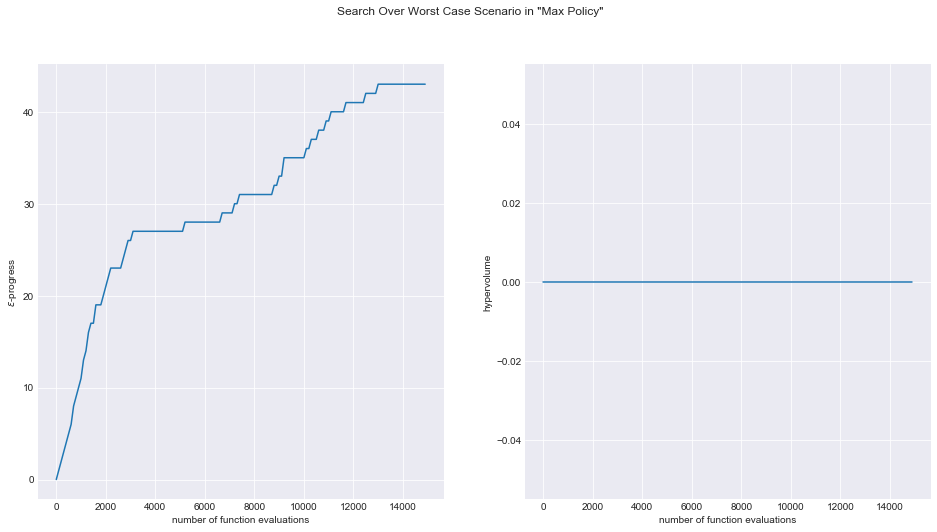

In [313]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(16,8))

ax1.plot(df_convergence_uncer_opt_max.nfe, df_convergence_uncer_opt_max.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(df_convergence_uncer_opt_max.nfe, df_convergence_uncer_opt_max.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.suptitle('Search Over Worst Case Scenario in "Max Policy"')
plt.show()

In [314]:
b = results_uncer_opt_max.sort_values(by='Expected Number of Deaths',ascending=False)[(
    list(dike_model.uncertainties.keys()))].to_dict('records')

In [315]:
b[0]['A.1_Brate'] = b[0]['A.1_Brate'].value
b[0]['A.2_Brate'] = b[0]['A.2_Brate'].value
b[0]['A.3_Brate'] = b[0]['A.3_Brate'].value
b[0]['A.4_Brate'] = b[0]['A.4_Brate'].value
b[0]['A.5_Brate'] = b[0]['A.5_Brate'].value
b[0]['discount rate'] = b[0]['discount rate'].value

In [316]:
results_uncer_opt_max = pd.DataFrame(b[0],index=[0])
results_uncer_opt_max.to_csv('results_uncer_opt_max.csv', encoding='utf-8', index=False)
df_results_uncer_opt_max = pd.read_csv('results_uncer_opt_max.csv')

In [369]:
df_results_uncer_opt_max.to_dict('records')[0]

{'A.0_ID flood wave shape': 89.0,
 'A.1_Bmax': 60.739106257414477,
 'A.1_Brate': 0.90000000000000002,
 'A.1_pfail': 4.7069089219977264e-09,
 'A.2_Bmax': 179.3402266656237,
 'A.2_Brate': 1.5,
 'A.2_pfail': 2.3204580157532018e-05,
 'A.3_Bmax': 178.94645538021388,
 'A.3_Brate': 1.5,
 'A.3_pfail': 1.3668814111251075e-15,
 'A.4_Bmax': 315.65016646150963,
 'A.4_Brate': 1000.0,
 'A.4_pfail': 0.11706457294009218,
 'A.5_Bmax': 192.08610132893986,
 'A.5_Brate': 1.5,
 'A.5_pfail': 7.9238418444321695e-18,
 'discount rate': 1.5}

In [370]:
worst_scenario_in_max = Scenario("Worst_in_max", **df_results_uncer_opt_max.to_dict('records')[0])

### 4.1.3 SOBOL in worst case for policy levers

In [889]:
start = time.time()

n_policies = 250

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_sobol_next = evaluator.perform_experiments([worst_scenario_in_max,worst_scenario_in_0], policies = n_policies, 
                                                    uncertainty_sampling= SOBOL, levers_sampling=SOBOL)
end = time.time()

print('Processing time :',(end - start)/60, 'Minutes')
experiments_sobol_next, outcomes_sobol_next = results_sobol_next

policies = experiments_sobol_next['policy']

for i, policy in enumerate(set(policies)):
    policies[policies==policy] = str(i)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2 scenarios * 6000 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Processing time : 25.7875736117363 Minutes


In [890]:
dfexperiment_sobol_next = pd.DataFrame(data=experiments_sobol_next)
dfoutput_sobol_next = pd.DataFrame(data=outcomes_sobol_next)
dfcombined_sobol_next = pd.concat([dfexperiment_sobol_next, dfoutput_sobol_next], axis=1)

dfexperiment_sobol_next.to_csv('dfexperiment_sobol_next.csv', encoding='utf-8', index=False)
dfoutput_sobol_next.to_csv('dfoutput_sobol_next.csv', encoding='utf-8', index=False)
dfcombined_sobol_next.to_csv('dfcombined_sobol_next.csv', encoding='utf-8', index=False)

In [891]:
df_experiment_sobol_next = pd.read_csv('dfexperiment_sobol_next.csv')
df_output_sobol_next = pd.read_csv('dfoutput_sobol_next.csv')
df_combined_sobol_next = pd.read_csv('dfcombined_sobol_next.csv')

In [892]:
select_scenario_0 = (df_experiment_sobol_next.scenario_id == 'Worst_in_Zero')
select_scenario_max = (df_experiment_sobol_next.scenario_id == 'Worst_in_max')

no_scenario_0 = df_output_sobol_next[select_scenario_0]['Expected Number of Deaths'].values
max_scenario_0 = df_output_sobol_next[select_scenario_max]['Expected Number of Deaths'].values

sobol_problem_levers = problem= get_SALib_problem(dike_model.levers)

c_scores1 = sobol.analyze(problem, no_scenario_0, calc_second_order=True, print_to_console=False)
c_scores2 = sobol.analyze(problem, max_scenario_0, calc_second_order=True, print_to_console=False)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:123: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


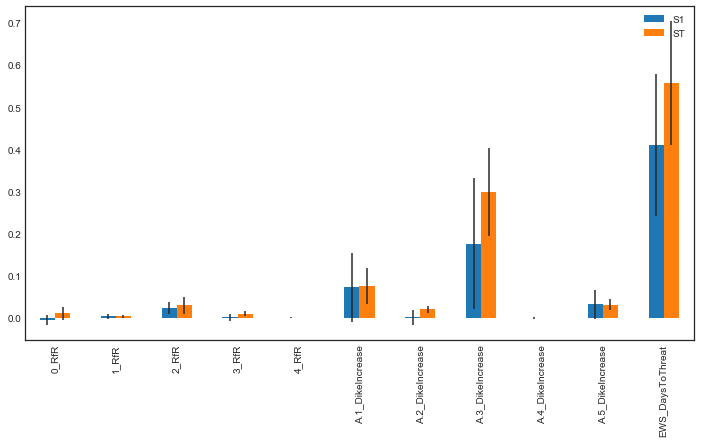

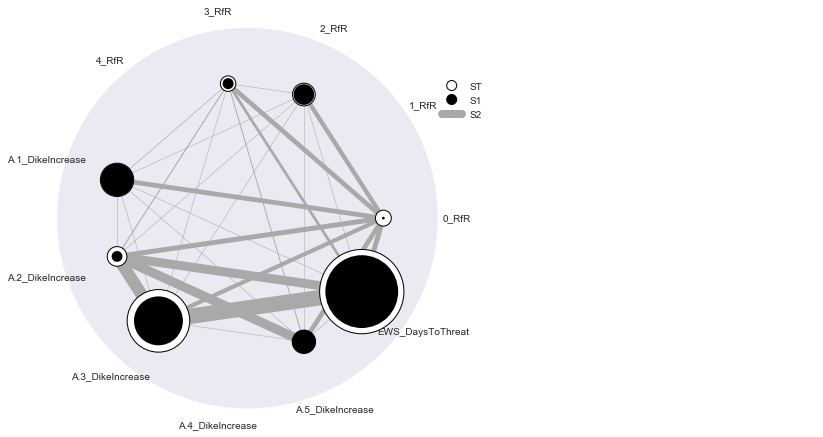

In [893]:
plot_scores(c_scores1)

sns.set_style('darkgrid')
fig = plot_sobol_indices(c_scores1, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)

plt.show()

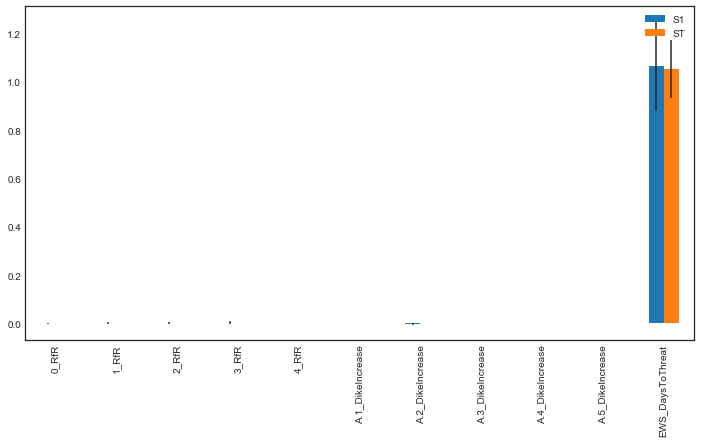

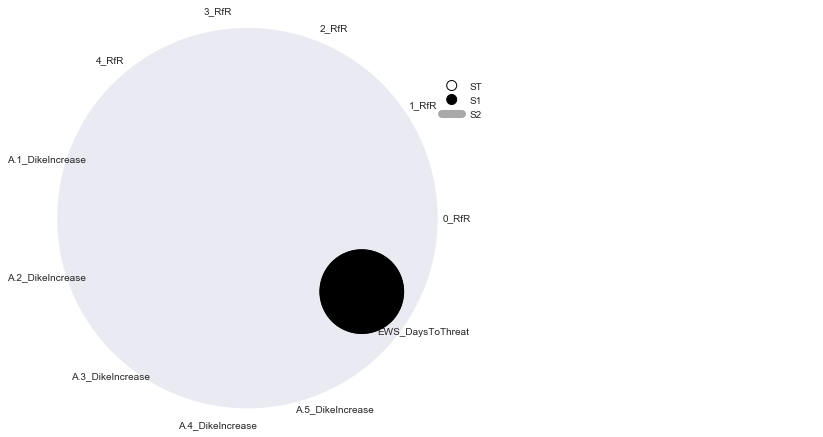

In [894]:
plot_scores(c_scores2)
sns.set_style('darkgrid')

fig = plot_sobol_indices(c_scores2, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)

plt.show()

### 4.2 Search over Levers

#### 4.2.1 MORDM with "The End of the day" (Moderate Level)

In [888]:
# change outcomes so direction is undesirable for the uncertainty
minimize = ScalarOutcome.MINIMIZE
maximize = ScalarOutcome.MAXIMIZE

for outcome in dike_model.outcomes:
    if outcome.kind == minimize:
        outcome.kind = maximize
    else:
        outcome.kind = minimize

In [429]:
best_min_threshold_1 = 0.002
# best_min_threshold_2 = 3.5e+08

const = [Constraint("Death", outcome_names="Expected Number of Deaths",
                         function=lambda x: max(0,x-best_min_threshold_1))
#          ,Constraint("Costs", outcome_names="Total Construction Costs",
#                          function=lambda x: max(0,x-best_min_threshold_2))
       ]

nfe = 10000

convergence_metrics = [
                       HyperVolume( 
                                    minimum=obj_min, 
                                    maximum=obj_max),
                       EpsilonProgress()
                      ]

espilon = [0.001,100,1e3,1e4]

In [430]:
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
        results_levers_opt_0, convergence_levers_0 = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=espilon,
                                                  convergence=convergence_metrics,
                                                  reference=worst_scenario_in_0,
                                                  constraints=const
                                                  )
        
results_levers_opt_0.to_csv('results_levers_opt_0.csv', encoding='utf-8', index=False)
convergence_levers_0.to_csv('convergence_levers_0.csv', encoding='utf-8', index=False)

end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 198/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 298/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProce

[MainProcess/INFO] performing 1 scenarios * 97 policies * 1 model(s) = 97 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 31: 3006/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 96 policies * 1 model(s) = 96 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 32: 3102/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 87 policies * 1 model(s) = 87 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] 87 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 33: 3189/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 95 policies * 1 model(s) = 95 experiments
[MainProcess/INFO] 32 cases completed
[MainProc

[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 60: 5736/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 90 policies * 1 model(s) = 90 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 61: 5826/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 92 policies * 1 model(s) = 92 experiments
[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 62: 5918/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 90 policies * 1 model(s) = 90 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 63: 6008/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 92 policies * 1 model(s) = 92 experime

[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 90: 8575/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 91: 8674/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 95 policies * 1 model(s) = 95 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 92: 8769/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 97 policies * 1 model(s) = 97 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO

Processing time : 18.686180222034455 Minutes


In [431]:
df_results_levers_opt_0 = pd.read_csv('results_levers_opt_0.csv')
df_convergence_levers_0= pd.read_csv('convergence_levers_0.csv')

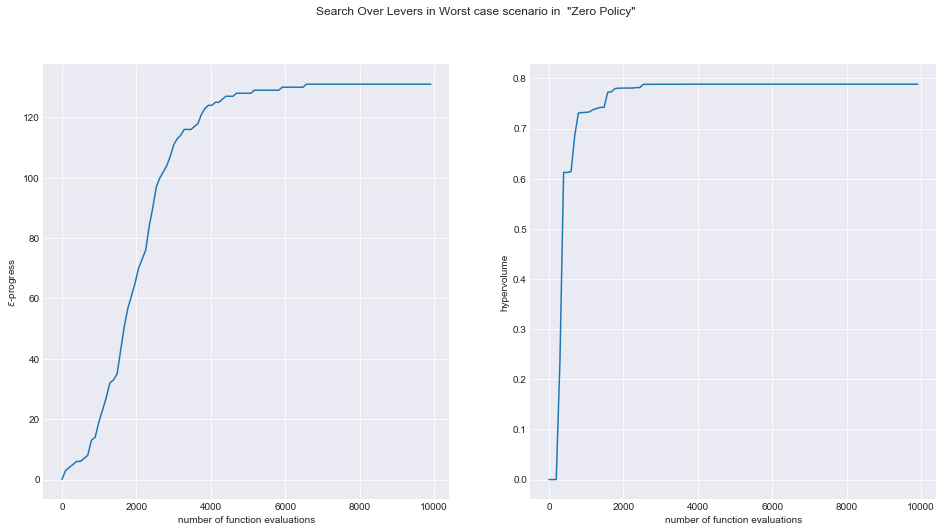

In [434]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(16,8))

ax1.plot(df_convergence_levers_0.nfe, df_convergence_levers_0.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(df_convergence_levers_0.nfe, df_convergence_levers_0.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.suptitle('Search Over Levers in Worst case scenario in  "Zero Policy"')
plt.show()

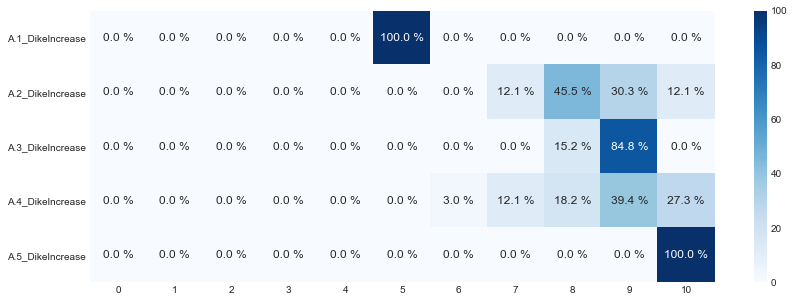

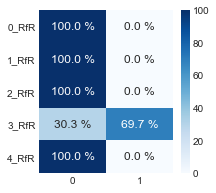

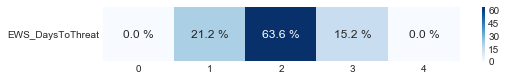

In [536]:
df_dike_range_0 = pd.DataFrame(index=list(dike_model.levers.keys())[0:5],columns=range(0,11))
df_rfr_range_0 = pd.DataFrame(index=list(dike_model.levers.keys())[6:11],columns=range(0,2))
df_EWS_range_0 = pd.DataFrame(index=range(0,5))

for levers in (list(dike_model.levers.keys()))[0:5]:
    for i in range(0,11):
        df_dike_range_0.at[levers, i] = len(df_results_levers_opt_0[
            df_results_levers_opt_0[levers].isin([i])])*100/len(df_results_levers_opt_0)

for levers in (list(dike_model.levers.keys()))[6:11]:
    for i in range(0,2):
        df_rfr_range_0.at[levers, i] = len(df_results_levers_opt_0[
            df_results_levers_opt_0[levers].isin([i])])*100/len(df_results_levers_opt_0)
        
levers = (list(dike_model.levers.keys()))[5]
for i in range(0,5):
    df_EWS_range_0.at[i, levers] = len(df_results_levers_opt_0[
        df_results_levers_opt_0[levers].isin([i])])*100/len(df_results_levers_opt_0)

fig, ax1 = plt.subplots(figsize=(14,5))  
sns.heatmap(df_dike_range_0.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
for t in ax1.texts: t.set_text(t.get_text() + " %")

fig, ax2 = plt.subplots(figsize=(3,3))  
sns.heatmap(df_rfr_range_0.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax2.texts: t.set_text(t.get_text() + " %")

fig, ax3 = plt.subplots(figsize=(8,1))  
sns.heatmap(df_EWS_range_0.astype(float).T,annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax3.texts: t.set_text(t.get_text() + " %")
plt.show()

#### 4.2.2 MORDM with "The End of the Day" Scenario (Extreme level)

In [454]:
best_min_threshold_1 = 0.002
# best_min_threshold_2 = 3.5e+08

const = [Constraint("Death", outcome_names="Expected Number of Deaths",
                         function=lambda x: max(0,x-best_min_threshold_1))
#          ,Constraint("Costs", outcome_names="Total Construction Costs",
#                          function=lambda x: max(0,x-best_min_threshold_2))
       ]

nfe = 10000

convergence_metrics = [
                       HyperVolume( 
                                    minimum=obj_min, 
                                    maximum=obj_max),
                       EpsilonProgress()
                      ]

espilon = [0.001,100,1e3,1e4]

In [455]:
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
        results_levers_opt_max, convergence_levers_max = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=espilon,
                                                  convergence=convergence_metrics,
                                                  reference=worst_scenario_in_max,
                                                  constraints=const
                                                  )
        
results_levers_opt_max.to_csv('results_levers_opt_max.csv', encoding='utf-8', index=False)
convergence_levers_max.to_csv('convergence_levers_max.csv', encoding='utf-8', index=False)

end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 299/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies *

[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 30: 2899/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 96 policies * 1 model(s) = 96 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 31: 2995/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 93 policies * 1 model(s) = 93 experiments
[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] 93 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 32: 3088/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 96 policies * 1 model(s) = 96 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO

[MainProcess/INFO] generation 59: 5604/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 97 policies * 1 model(s) = 97 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 60: 5701/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 90 policies * 1 model(s) = 90 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 61: 5791/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 97 policies * 1 model(s) = 97 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 62: 5888/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 91 policies * 1 model(s) = 91 experiment

[MainProcess/INFO] performing 1 scenarios * 97 policies * 1 model(s) = 97 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 89: 8428/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 93 policies * 1 model(s) = 93 experiments
[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] 93 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 90: 8521/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 95 policies * 1 model(s) = 95 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 91: 8616/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 94 policies * 1 model(s) = 94 experiments
[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProc

Processing time : 76.8364930152893 Minutes


In [456]:
df_results_levers_opt_max = pd.read_csv('results_levers_opt_max.csv')
df_convergence_levers_max = pd.read_csv('convergence_levers_max.csv')

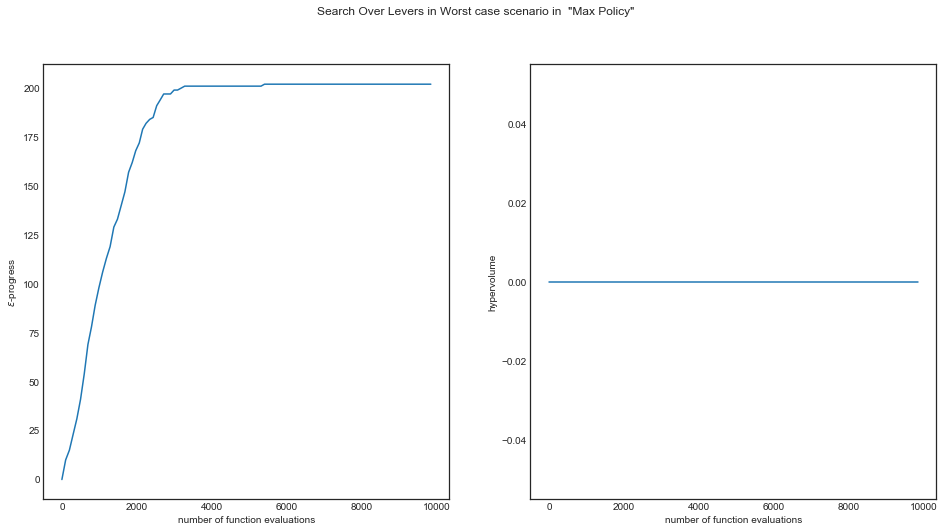

In [816]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(16,8))

ax1.plot(df_convergence_levers_max.nfe, df_convergence_levers_max.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(df_convergence_levers_max.nfe, df_convergence_levers_max.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.suptitle('Search Over Levers in Worst case scenario in  "Max Policy"')
plt.show()

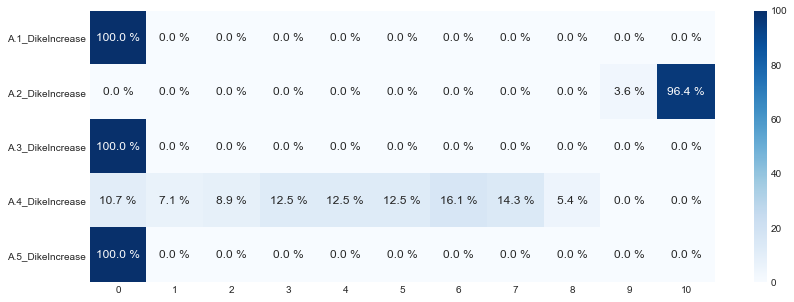

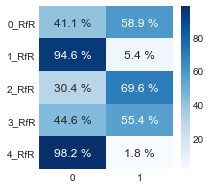

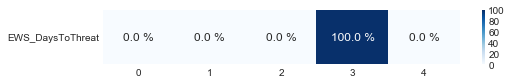

In [532]:
df_dike_range_max = pd.DataFrame(index=list(dike_model.levers.keys())[0:5],columns=range(0,11))
df_rfr_range_max = pd.DataFrame(index=list(dike_model.levers.keys())[6:11],columns=range(0,2))
df_EWS_range_max = pd.DataFrame(index=range(0,5))

for levers in (list(dike_model.levers.keys()))[0:5]:
    for i in range(0,11):
        df_dike_range_max.at[levers, i] = len(df_results_levers_opt_max[
            df_results_levers_opt_max[levers].isin([i])])*100/len(df_results_levers_opt_max)

for levers in (list(dike_model.levers.keys()))[6:11]:
    for i in range(0,2):
        df_rfr_range_max.at[levers, i] = len(df_results_levers_opt_max[
            df_results_levers_opt_max[levers].isin([i])])*100/len(df_results_levers_opt_max)
        
levers = (list(dike_model.levers.keys()))[5]
for i in range(0,5):
    df_EWS_range_max.at[i, levers] = len(df_results_levers_opt_max[
        df_results_levers_opt_max[levers].isin([i])])*100/len(df_results_levers_opt_max)

fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(df_dike_range_max.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
for t in ax.texts: t.set_text(t.get_text() + " %")

fig, ax = plt.subplots(figsize=(3,3))  
sns.heatmap(df_rfr_range_max.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")

fig, ax = plt.subplots(figsize=(8,1))  
sns.heatmap(df_EWS_range_max.astype(float).T,annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")
    
plt.show()

#### 4.2.3 MORDM with "Fragile Dikes" Scenario

In [462]:
best_min_threshold_1 = 0.0005
# best_min_threshold_2 = 3.5e+08

const = [Constraint("Death", outcome_names="Expected Number of Deaths",
                         function=lambda x: max(0,x-best_min_threshold_1))
#          ,Constraint("Costs", outcome_names="Total Construction Costs",
#                          function=lambda x: max(0,x-best_min_threshold_2))
       ]
nfe = 10000

convergence_metrics = [
                       HyperVolume( 
                                    minimum=obj_min, 
                                    maximum=obj_max),
                       EpsilonProgress()
                      ]

espilon = [0.001,100,1e3,1e4]

In [463]:
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
        results_levers_opt_dikes, convergence_levers_dikes = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=espilon,
                                                  convergence=convergence_metrics,
                                                  reference=dikes_scenario_ref,
                                                  constraints=const
                                                  )
        
results_levers_opt_dikes.to_csv('results_levers_opt_dikes.csv', encoding='utf-8', index=False)
convergence_levers_dikes.to_csv('convergence_levers_dikes.csv', encoding='utf-8', index=False)

end = time.time()

print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 300/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies

[MainProcess/INFO] 93 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 30: 2884/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 91 policies * 1 model(s) = 91 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 31: 2975/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 92 policies * 1 model(s) = 92 experiments
[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 32: 3067/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 91 policies * 1 model(s) = 91 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 33: 3158/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 

[MainProcess/INFO] generation 60: 5491/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 86 policies * 1 model(s) = 86 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 61: 5577/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 96 policies * 1 model(s) = 96 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 62: 5673/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 86 policies * 1 model(s) = 86 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 63: 5759/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 88 policies * 1 model(s) = 88 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases complete

[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 90: 8117/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 88 policies * 1 model(s) = 88 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] 87 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 91: 8205/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 94 policies * 1 model(s) = 94 experiments
[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] 93 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 92: 8299/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 89 policies * 1 model(s) = 89 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 93: 8388/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 87 policies * 1 model(s) = 87 experime

[MainProcess/INFO] 14 cases completed
[MainProcess/INFO] 21 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 120: 9407/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 22 policies * 1 model(s) = 22 experiments
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 14 cases completed
[MainProcess/INFO] 21 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 121: 9429/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 20 policies * 1 model(s) = 20 experiments
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 14 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 122: 9449/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 23 policies * 1 model(s) = 23 experiments
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 123: 9472/10000 nfe
[MainProcess/INFO] performing 1 scenarios *

Processing time : 19.481516039371492 Minutes


In [464]:
df_results_levers_opt_dikes = pd.read_csv('results_levers_opt_dikes.csv')
df_convergence_levers_dikes = pd.read_csv('convergence_levers_dikes.csv')

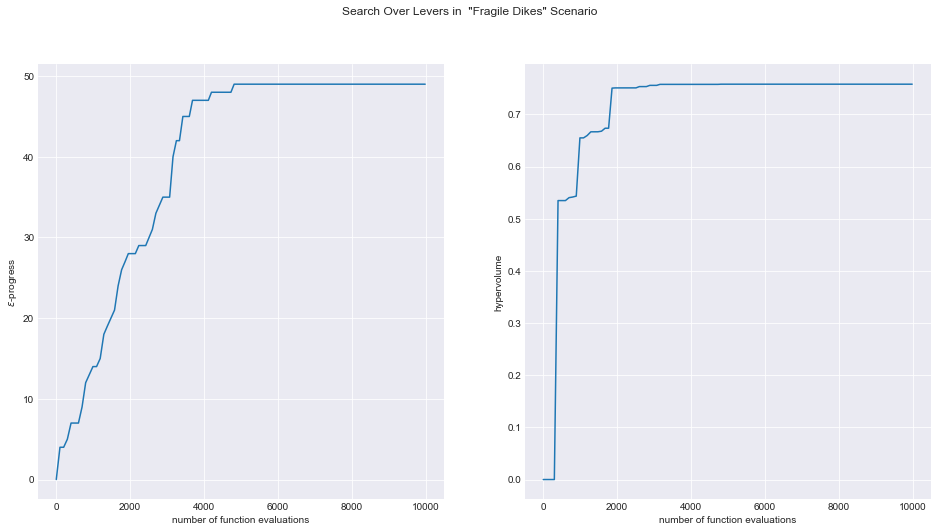

In [467]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(16,8))

ax1.plot(df_convergence_levers_dikes.nfe, df_convergence_levers_dikes.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(df_convergence_levers_dikes.nfe, df_convergence_levers_dikes.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.suptitle('Search Over Levers in  "Fragile Dikes" Scenario')
plt.show()

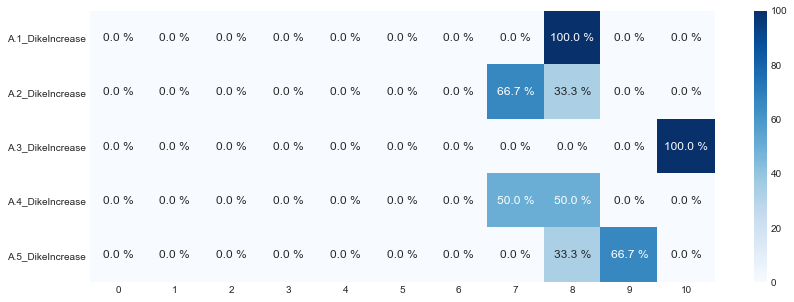

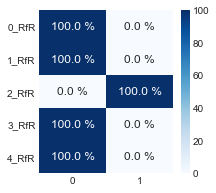

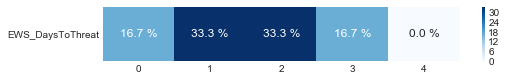

In [530]:
df_dike_range_dikes = pd.DataFrame(index=list(dike_model.levers.keys())[0:5],columns=range(0,11))
df_rfr_range_dikes = pd.DataFrame(index=list(dike_model.levers.keys())[6:11],columns=range(0,2))
df_EWS_range_dikes = pd.DataFrame(index=range(0,5))

for levers in (list(dike_model.levers.keys()))[0:5]:
    for i in range(0,11):
        df_dike_range_dikes.at[levers, i] = len(df_results_levers_opt_dikes[
            df_results_levers_opt_dikes[levers].isin([i])])*100/len(df_results_levers_opt_dikes)

for levers in (list(dike_model.levers.keys()))[6:11]:
    for i in range(0,2):
        df_rfr_range_dikes.at[levers, i] = len(df_results_levers_opt_dikes[
            df_results_levers_opt_dikes[levers].isin([i])])*100/len(df_results_levers_opt_dikes)

levers = (list(dike_model.levers.keys()))[5]
for i in range(0,5):
    df_EWS_range_dikes.at[i, levers] = len(df_results_levers_opt_dikes[
        df_results_levers_opt_dikes[levers].isin([i])])*100/len(df_results_levers_opt_dikes)
        
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(df_dike_range_dikes.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
for t in ax.texts: t.set_text(t.get_text() + " %")
       
fig, ax = plt.subplots(figsize=(3,3))  
sns.heatmap(df_rfr_range_dikes.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")

fig, ax = plt.subplots(figsize=(8,1))  
sns.heatmap(df_EWS_range_dikes.astype(float).T,annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")

plt.show()

#### 4.2.4 MORDM with "Catastrophy" Scenario

In [470]:
best_min_threshold_1 = 0.0005
# best_min_threshold_2 = 3.5e+08

const = [Constraint("Death", outcome_names="Expected Number of Deaths",
                         function=lambda x: max(0,x-best_min_threshold_1))
#          ,Constraint("Costs", outcome_names="Total Construction Costs",
#                          function=lambda x: max(0,x-best_min_threshold_2))
       ]

nfe = 10000

convergence_metrics = [
                       HyperVolume( 
                                    minimum=obj_min, 
                                    maximum=obj_max),
                       EpsilonProgress()
                      ]

espilon = [0.001,100,1e3,1e4]

In [471]:
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
        results_levers_opt_catas, convergence_levers_catas = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=espilon,
                                                  convergence=convergence_metrics,
                                                  reference=catastrophy_scenario_ref 
                                                  ,constraints=const
                                                  )
        
results_levers_opt_catas.to_csv('results_levers_opt_catas.csv', encoding='utf-8', index=False)
convergence_levers_catas.to_csv('convergence_levers_catas.csv', encoding='utf-8', index=False)

end = time.time()

print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 300/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies

[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 30: 2794/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 88 policies * 1 model(s) = 88 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] 87 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 31: 2882/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 87 policies * 1 model(s) = 87 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] 87 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 32: 2969/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 92 policies * 1 model(s) = 92 experiments
[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 33: 3061/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 89 policies * 1 model(s) = 89 experime

[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] 87 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 60: 5487/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 85 policies * 1 model(s) = 85 experiments
[MainProcess/INFO] 28 cases completed
[MainProcess/INFO] 56 cases completed
[MainProcess/INFO] 84 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 61: 5572/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 90 policies * 1 model(s) = 90 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 62: 5662/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 93 policies * 1 model(s) = 93 experiments
[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] 93 cases completed
[MainProcess/INFO] 

[MainProcess/INFO] generation 89: 8073/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 94 policies * 1 model(s) = 94 experiments
[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] 93 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 90: 8167/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 90 policies * 1 model(s) = 90 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 91: 8257/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 90 policies * 1 model(s) = 90 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 92: 8347/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 94 policies * 1 model(s) = 94 experiment

[MainProcess/INFO] 13 cases completed
[MainProcess/INFO] 26 cases completed
[MainProcess/INFO] 39 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 119: 9761/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 35 policies * 1 model(s) = 35 experiments
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 120: 9796/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 37 policies * 1 model(s) = 37 experiments
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] 36 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 121: 9833/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 37 policies * 1 model(s) = 37 experiments
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] 36 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/I

Processing time : 19.051408052444458 Minutes


In [472]:
df_results_levers_opt_catas = pd.read_csv('results_levers_opt_catas.csv')
df_convergence_levers_catas = pd.read_csv('convergence_levers_catas.csv')

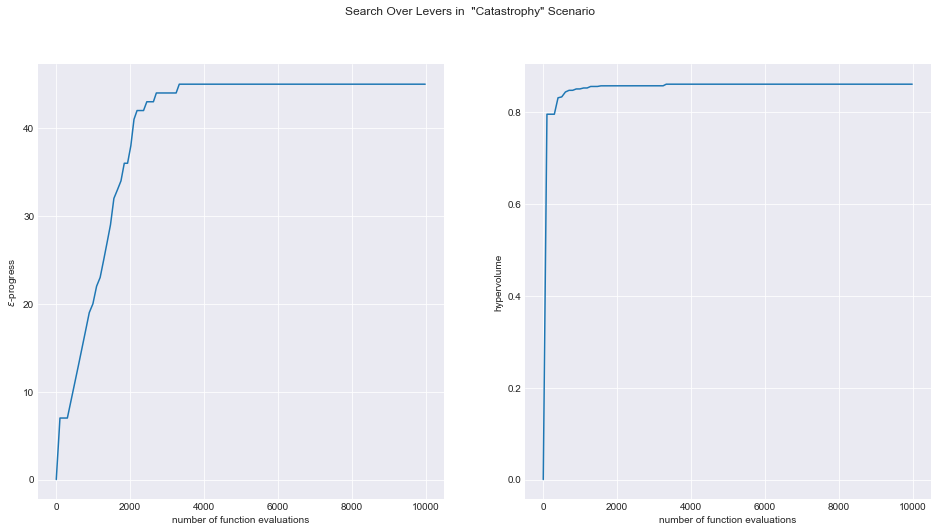

In [475]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(16,8))

ax1.plot(df_convergence_levers_catas.nfe, df_convergence_levers_catas.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(df_convergence_levers_catas.nfe, df_convergence_levers_catas.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.suptitle('Search Over Levers in  "Catastrophy" Scenario')
plt.show()

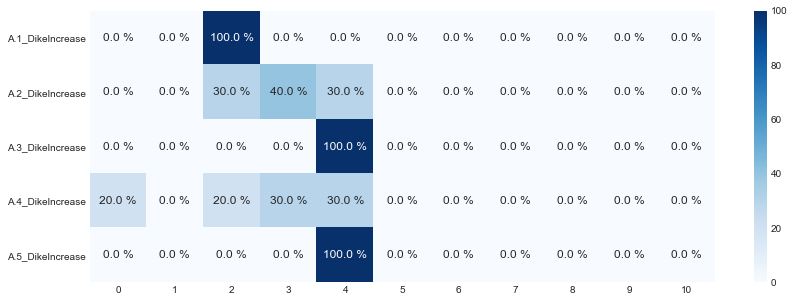

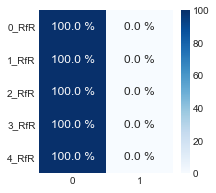

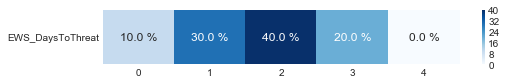

In [527]:
df_dike_range_catas = pd.DataFrame(index=list(dike_model.levers.keys())[0:5],columns=range(0,11))
df_rfr_range_catas = pd.DataFrame(index=list(dike_model.levers.keys())[6:11],columns=range(0,2))
df_EWS_range_catas= pd.DataFrame(index=range(0,5))

for levers in (list(dike_model.levers.keys()))[0:5]:
    for i in range(0,11):
        df_dike_range_catas.at[levers, i] = len(df_results_levers_opt_catas[
            df_results_levers_opt_catas[levers].isin([i])])*100/len(df_results_levers_opt_catas)

for levers in (list(dike_model.levers.keys()))[6:11]:
    for i in range(0,2):
        df_rfr_range_catas.at[levers, i] = len(df_results_levers_opt_catas[
            df_results_levers_opt_catas[levers].isin([i])])*100/len(df_results_levers_opt_catas)

levers = (list(dike_model.levers.keys()))[5]
for i in range(0,5):
    df_EWS_range_catas.at[i, levers] = len(df_results_levers_opt_catas[
        df_results_levers_opt_catas[levers].isin([i])])*100/len(df_results_levers_opt_catas)
        
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(df_dike_range_catas.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
for t in ax.texts: t.set_text(t.get_text() + " %")
    
fig, ax = plt.subplots(figsize=(3,3))  
sns.heatmap(df_rfr_range_catas.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")

fig, ax = plt.subplots(figsize=(8,1))  
sns.heatmap(df_EWS_range_catas.astype(float).T,annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")

plt.show()

#### 4.2.5 MORDM with Sunshine "50%" Scenario

In [478]:
best_min_threshold_1 = 0.0005
# best_min_threshold_2 = 3.5e+08

const = [Constraint("Death", outcome_names="Expected Number of Deaths",
                         function=lambda x: max(0,x-best_min_threshold_1))
#          ,Constraint("Costs", outcome_names="Total Construction Costs",
#                          function=lambda x: max(0,x-best_min_threshold_2))
       ]

nfe = 10000

convergence_metrics = [
                       HyperVolume( 
                                    minimum=obj_min, 
                                    maximum=obj_max),
                       EpsilonProgress()
                      ]

espilon = [0.001,100,1e3,1e4]

In [479]:
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
        results_levers_opt_50, convergence_levers_50 = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=espilon,
                                                  convergence=convergence_metrics,
                                                  reference=percent_50_scenario_ref
                                                  ,constraints=const
                                                  )
        
results_levers_opt_50.to_csv('results_levers_opt_50.csv', encoding='utf-8', index=False)
convergence_levers_50.to_csv('convergence_levers_50.csv', encoding='utf-8', index=False)

end = time.time()

print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 298/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProce

[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 30: 2821/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 88 policies * 1 model(s) = 88 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] 87 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 31: 2909/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 96 policies * 1 model(s) = 96 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 32: 3005/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 90 policies * 1 model(s) = 90 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 33: 3095/10000 nfe
[MainP

[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] 87 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 60: 5517/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 90 policies * 1 model(s) = 90 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 61: 5607/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 91 policies * 1 model(s) = 91 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 62: 5698/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 85 policies * 1 model(s) = 85 experiments
[MainProcess/INFO] 28 cases completed
[MainProcess/INFO] 56 cases completed
[MainProcess/INFO] 84 cases completed
[MainProcess/INFO] 

[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] 93 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 89: 8109/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 88 policies * 1 model(s) = 88 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] 87 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 90: 8197/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 90 policies * 1 model(s) = 90 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 91: 8287/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 91 policies * 1 model(s) = 91 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO

[MainProcess/INFO] 36 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 118: 9766/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 38 policies * 1 model(s) = 38 experiments
[MainProcess/INFO] 13 cases completed
[MainProcess/INFO] 26 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 119: 9804/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 35 policies * 1 model(s) = 35 experiments
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 120: 9839/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 35 policies * 1 model(s) = 35 experiments
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 121: 9874/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 35 policies * 1 model(s) = 35 experiments
[MainProcess/INFO] 12 cases co

Processing time : 19.008551049232484 Minutes


In [480]:
df_results_levers_opt_50 = pd.read_csv('results_levers_opt_50.csv')
df_convergence_levers_50 = pd.read_csv('convergence_levers_50.csv')

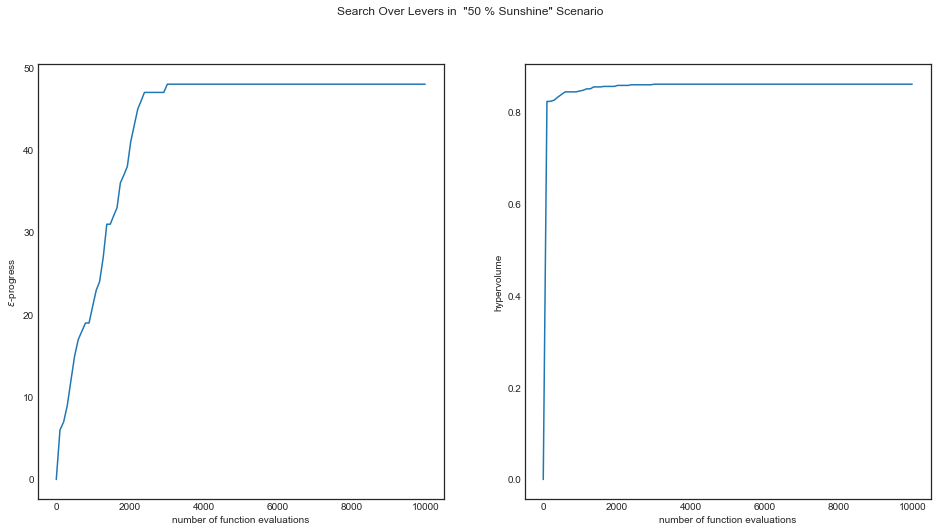

In [818]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(16,8))

ax1.plot(df_convergence_levers_50.nfe, df_convergence_levers_50.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(df_convergence_levers_50.nfe, df_convergence_levers_50.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.suptitle('Search Over Levers in  "50 % Sunshine" Scenario')
plt.show()

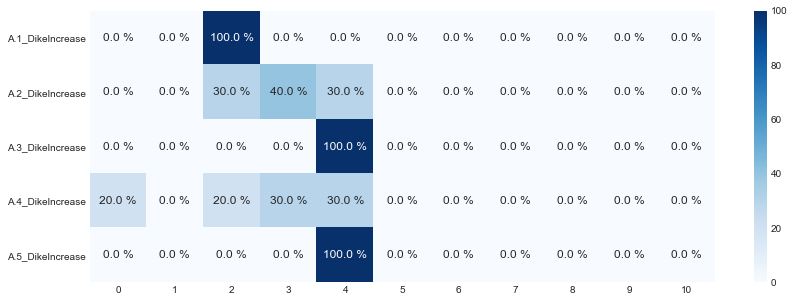

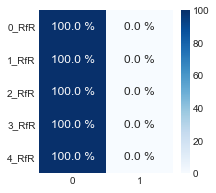

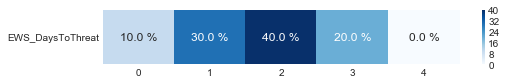

In [528]:
df_dike_range_50 = pd.DataFrame(index=list(dike_model.levers.keys())[0:5],columns=range(0,11))
df_rfr_range_50 = pd.DataFrame(index=list(dike_model.levers.keys())[6:11],columns=range(0,2))
df_EWS_range_50= pd.DataFrame(index=range(0,5))

for levers in (list(dike_model.levers.keys()))[0:5]:
    for i in range(0,11):
        df_dike_range_50.at[levers, i] = len(df_results_levers_opt_50[
            df_results_levers_opt_50[levers].isin([i])])*100/len(df_results_levers_opt_50)

for levers in (list(dike_model.levers.keys()))[6:11]:
    for i in range(0,2):
        df_rfr_range_50.at[levers, i] = len(df_results_levers_opt_50[
            df_results_levers_opt_50[levers].isin([i])])*100/len(df_results_levers_opt_50)

levers = (list(dike_model.levers.keys()))[5]
for i in range(0,5):
    df_EWS_range_50.at[i, levers] = len(df_results_levers_opt_50[
        df_results_levers_opt_50[levers].isin([i])])*100/len(df_results_levers_opt_50)
        
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(df_dike_range_50.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
for t in ax.texts: t.set_text(t.get_text() + " %")
    
fig, ax = plt.subplots(figsize=(3,3))  
sns.heatmap(df_rfr_range_50.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")

fig, ax = plt.subplots(figsize=(8,1))  
sns.heatmap(df_EWS_range_50.astype(float).T,annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")

plt.show()

#### 4.2.6 MORDM with Sunshine "25%" Scenario

In [486]:
best_min_threshold_1 = 0.0005
# best_min_threshold_2 = 3.5e+08

const = [Constraint("Death", outcome_names="Expected Number of Deaths",
                         function=lambda x: max(0,x-best_min_threshold_1))
#          ,Constraint("Costs", outcome_names="Total Construction Costs",
#                          function=lambda x: max(0,x-best_min_threshold_2))
       ]

nfe = 10000

convergence_metrics = [
                       HyperVolume( 
                                    minimum=obj_min, 
                                    maximum=obj_max),
                       EpsilonProgress()
                      ]

espilon = [0.001,100,1e3,1e4]

In [487]:
start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
        results_levers_opt_25, convergence_levers_25 = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=espilon,
                                                  convergence=convergence_metrics,
                                                  reference=percent_25_scenario_ref
                                                  ,constraints=const
                                                  )
        
results_levers_opt_25.to_csv('results_levers_opt_25.csv', encoding='utf-8', index=False)
convergence_levers_25.to_csv('convergence_levers_25.csv', encoding='utf-8', index=False)

end = time.time()

print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 300/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies

[MainProcess/INFO] 28 cases completed
[MainProcess/INFO] 56 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 30: 2860/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 88 policies * 1 model(s) = 88 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] 87 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 31: 2948/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 90 policies * 1 model(s) = 90 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 32: 3038/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 88 policies * 1 model(s) = 88 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] 87 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO

[MainProcess/INFO] 27 cases completed
[MainProcess/INFO] 54 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 60: 5497/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 94 policies * 1 model(s) = 94 experiments
[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] 93 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 61: 5591/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 93 policies * 1 model(s) = 93 experiments
[MainProcess/INFO] 31 cases completed
[MainProcess/INFO] 62 cases completed
[MainProcess/INFO] 93 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 62: 5684/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 86 policies * 1 model(s) = 86 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 63: 5770/10000 nfe
[MainP

[MainProcess/INFO] generation 90: 8134/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 91 policies * 1 model(s) = 91 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 91: 8225/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 91 policies * 1 model(s) = 91 experiments
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 92: 8316/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 87 policies * 1 model(s) = 87 experiments
[MainProcess/INFO] 29 cases completed
[MainProcess/INFO] 58 cases completed
[MainProcess/INFO] 87 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 93: 8403/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 96 policies * 1 model(s) = 96 experiment

[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 120: 9709/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 34 policies * 1 model(s) = 34 experiments
[MainProcess/INFO] 11 cases completed
[MainProcess/INFO] 22 cases completed
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 121: 9743/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 37 policies * 1 model(s) = 37 experiments
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] 36 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 122: 9780/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 35 policies * 1 model(s) = 35 experiments
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 123: 9815/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 34 policies * 1 model(s) = 34 expe

Processing time : 19.03519659837087 Minutes


In [488]:
df_results_levers_opt_25 = pd.read_csv('results_levers_opt_25.csv')
df_convergence_levers_25 = pd.read_csv('convergence_levers_25.csv')

In [489]:
df_results_levers_opt_25.sort_values(by='Expected Number of Deaths').head()

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,EWS_DaysToThreat,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,Expected Number of Deaths,Expected Evacuation Costs,Expected Annual Damage,Total Construction Costs
0,1,3,4,4,5,2,0,0,0,0,0,0.000000,0.000000,0.000000e+00,1.374334e+08
2,1,3,4,3,5,0,0,0,0,0,0,0.000038,0.000000,6.876667e+04,1.366004e+08
4,1,3,4,2,5,1,0,0,0,0,0,0.000221,29.132869,1.128258e+06,1.358131e+08
1,1,3,4,0,5,2,0,0,0,0,0,0.000326,192.988028,4.237751e+06,1.289575e+08
7,1,3,3,3,5,2,0,0,0,0,0,0.000398,50.462027,1.630285e+06,1.353952e+08


In [490]:
len(df_results_levers_opt_25)

9

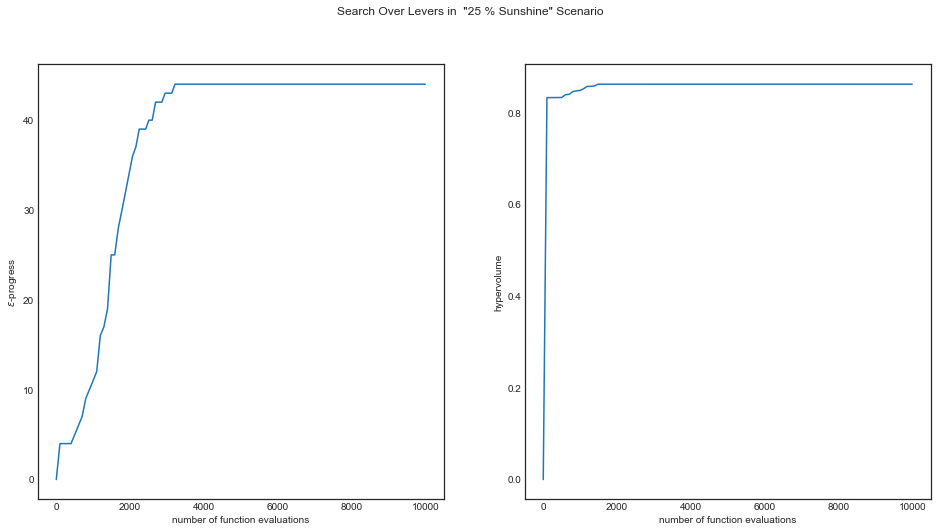

In [817]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(16,8))

ax1.plot(df_convergence_levers_25.nfe, df_convergence_levers_25.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(df_convergence_levers_25.nfe, df_convergence_levers_25.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.suptitle('Search Over Levers in  "25 % Sunshine" Scenario')
plt.show()

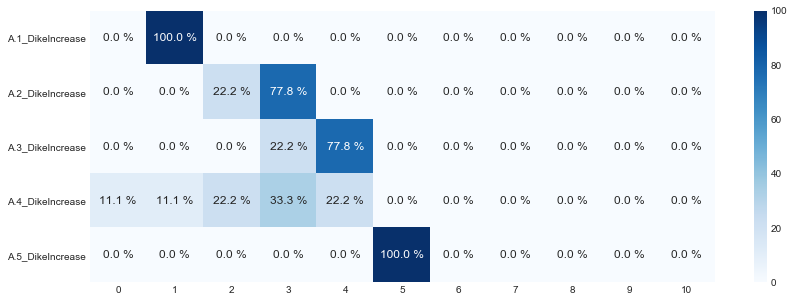

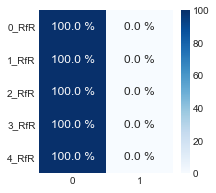

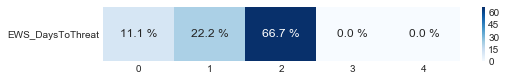

In [529]:
df_dike_range_25 = pd.DataFrame(index=list(dike_model.levers.keys())[0:5],columns=range(0,11))
df_rfr_range_25 = pd.DataFrame(index=list(dike_model.levers.keys())[6:11],columns=range(0,2))
df_EWS_range_25 = pd.DataFrame(index=range(0,5))

for levers in (list(dike_model.levers.keys()))[0:5]:
    for i in range(0,11):
        df_dike_range_25.at[levers, i] = len(df_results_levers_opt_25[
            df_results_levers_opt_25[levers].isin([i])])*100/len(df_results_levers_opt_25)

for levers in (list(dike_model.levers.keys()))[6:11]:
    for i in range(0,2):
        df_rfr_range_25.at[levers, i] = len(df_results_levers_opt_25[
            df_results_levers_opt_25[levers].isin([i])])*100/len(df_results_levers_opt_25)

levers = (list(dike_model.levers.keys()))[5]
for i in range(0,5):
    df_EWS_range_25.at[i, levers] = len(df_results_levers_opt_25[
        df_results_levers_opt_25[levers].isin([i])])*100/len(df_results_levers_opt_25)
        
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(df_dike_range_25.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
for t in ax.texts: t.set_text(t.get_text() + " %")
    
fig, ax = plt.subplots(figsize=(3,3))  
sns.heatmap(df_rfr_range_25.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")

fig, ax = plt.subplots(figsize=(8,1))  
sns.heatmap(df_EWS_range_25.astype(float).T,annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")

plt.show()

#### 4.2.7 MORO simulation results

In [146]:
df_results_levers_MORO = pd.read_csv('MORO_archive.csv')
df_convergence_levers_MORO = pd.read_csv('MORO_convergence.csv')

In [148]:
df_results_levers_MORO

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat,fraction Expected Number of Deaths,fraction Expected Evacuation Costs,fraction Expected Annual Damage,raw Total Construction Costs
0,6,9,9,10,9,0,0,0,0,0,2,1.000000,1.000000,0.833333,0.199972
1,8,10,9,10,9,0,0,0,0,0,3,1.000000,1.000000,0.933333,0.213271
2,4,4,8,0,5,0,0,0,0,0,2,0.866667,0.866667,0.000000,0.147980
3,4,3,6,2,5,0,0,0,0,0,3,0.833333,0.866667,0.033333,0.148612
4,3,3,7,3,6,0,0,0,0,0,3,0.833333,0.833333,0.100000,0.149104
5,3,4,6,5,4,0,0,0,0,0,3,0.766667,0.866667,0.166667,0.149087
6,4,0,7,0,5,0,0,0,0,0,3,0.666667,0.600000,0.000000,0.099885
7,3,4,6,0,7,0,0,0,0,0,1,0.633333,0.933333,0.000000,0.145482
8,4,0,8,0,4,0,0,0,0,0,2,0.600000,0.666667,0.000000,0.099507
9,3,4,5,2,6,0,0,0,0,0,1,0.533333,0.933333,0.066667,0.149006


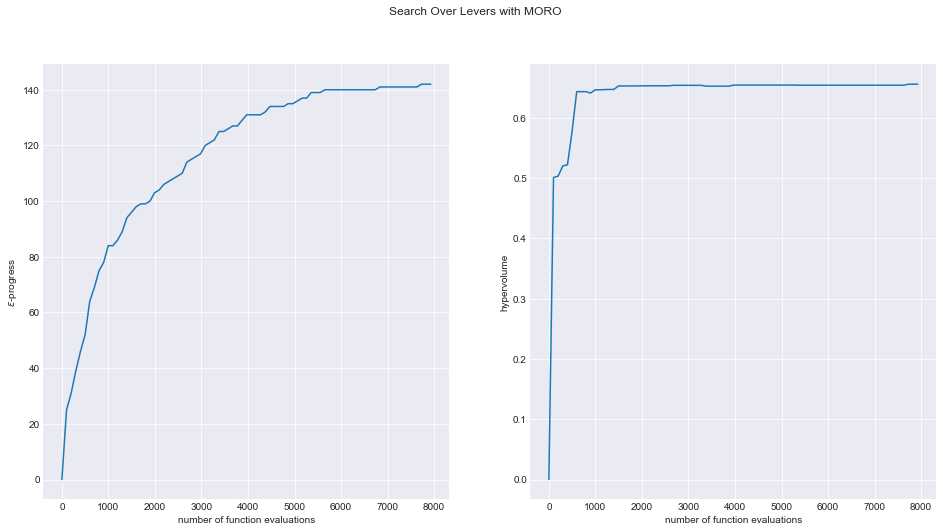

In [150]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(16,8))

ax1.plot(df_convergence_levers_MORO.nfe, df_convergence_levers_MORO.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(df_convergence_levers_MORO.nfe, df_convergence_levers_MORO.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.suptitle('Search Over Levers with MORO')
plt.show()

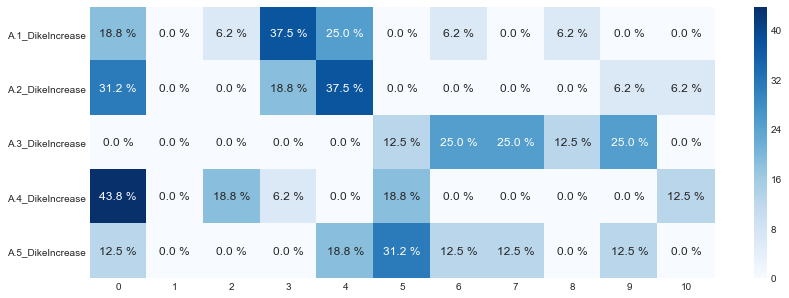

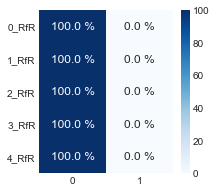

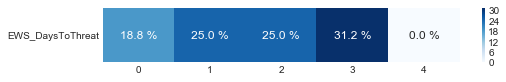

In [151]:
df_dike_range_MORO = pd.DataFrame(index=list(dike_model.levers.keys())[0:5],columns=range(0,11))
df_rfr_range_MORO = pd.DataFrame(index=list(dike_model.levers.keys())[6:11],columns=range(0,2))
df_EWS_range_MORO = pd.DataFrame(index=range(0,5))

for levers in (list(dike_model.levers.keys()))[0:5]:
    for i in range(0,11):
        df_dike_range_MORO.at[levers, i] = len(df_results_levers_MORO[df_results_levers_MORO[levers].isin([i])])*100/len(df_results_levers_MORO)

for levers in (list(dike_model.levers.keys()))[6:11]:
    for i in range(0,2):
        df_rfr_range_MORO.at[levers, i] = len(df_results_levers_MORO[df_results_levers_MORO[levers].isin([i])])*100/len(df_results_levers_MORO)

levers = (list(dike_model.levers.keys()))[5]
for i in range(0,5):
    df_EWS_range_MORO.at[i, levers] = len(df_results_levers_MORO[df_results_levers_MORO[levers].isin([i])])*100/len(df_results_levers_MORO)
    
# fig, (ax1,ax2,ax3) = plt.subplots(nrows = 3, figsize=(14,5))  
        
fig, ax = plt.subplots(figsize=(14,5))  
sns.heatmap(df_dike_range_MORO.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.show()
       
fig, ax = plt.subplots(figsize=(3,3))  
sns.heatmap(df_rfr_range_MORO.astype(float),annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.show()

fig, ax = plt.subplots(figsize=(8,1))  
sns.heatmap(df_EWS_range_MORO.astype(float).T,annot=True,annot_kws={"size": 12},fmt='.1f',cmap="Blues")
plt.yticks(rotation=360)
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.show()

#### 4.2.8 Converting All MORDM Optimization results to csv

In [501]:
dfopt_levers_combined = pd.concat([df_results_levers_opt_0, df_results_levers_opt_max,
                                  df_results_levers_opt_dikes,df_results_levers_opt_catas,
                                  df_results_levers_opt_50,df_results_levers_opt_25])
dfopt_levers_combined.to_csv('dfopt_levers_combined.csv', encoding='utf-8', index=False)

In [503]:
df_opt_levers_combined = pd.read_csv('dfopt_levers_combined.csv')

## 5. Testing Policies Ensemble

#### 5.1 Scenario definition

In [547]:
# pre-defined policy based on optimization

# Policy from MORDM Worst case scenario
policy_1a = Policy("Policy_End_Days_Moderate", **levers_parameter(5,9,9,9,10, 0,0,0,1,0,2)) #Lowest

policy_1b = Policy("Policy_End_Days_Extreme", **levers_parameter(0,10,0,6,0,1,1,1,1,1,3)) #Lowest

policy_1c = Policy("Policy_Fragile_Dikes_Scenario", **levers_parameter(8,7,10,8,9,0,0,1,0,0,2)) # Most

policy_1d = Policy("Policy_Catastrophy_Dikes_Scenario", **levers_parameter(2,4,4,4,4,0,0,0,0,0,2))  #Lowest

policy_1e = Policy("Policy_Sunshine_50_Scenario", **levers_parameter(2,3,4,4,4, 0,0,0,0,0,2)) #Most

policy_1f = Policy("Policy_Sunshine_25_Scenario", **levers_parameter(1,3,4,4,5, 0,0,0,0,0,2)) #Lowest

# Policy from MORO case scenario
policy_2a = Policy("Policy_MORO_High", **levers_parameter(8,10,9,10,9,0,0,0,0,0,3))

policy_2b = Policy("Policy_MORO_Mid", **levers_parameter(8,8,10,9,10,0,0,0,0,0,3))

policy_2c = Policy("Policy_MORO_Low", **levers_parameter(6,9,9,10,9,0,0,0,0,0,2))

policy_2d = Policy("Policy_MORO_RfR", **levers_parameter(7,8,9,5,9,0,0,0,1,0,3))


In [ ]:
# number scenarios
n_scenarios = 2500

start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results2 = evaluator.perform_experiments(n_scenarios, [#policy_0,policy_max
                                                          policy_1a,policy_1b
                                                          ,policy_1c,policy_1d
                                                          ,policy_1e,policy_1f
                                                          ,policy_2a,policy_2b
                                                          ,policy_2c,policy_2d
                                                          ])
    
end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2500 scenarios * 10 policies * 1 model(s) = 25000 experiments
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 7500 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 12500 cases completed
[MainProcess/INFO] 15000 cases completed
[MainProcess/INFO] 17500 cases completed


In [ ]:
experiments2, outcomes2 = results2
dfexperiment2 = pd.DataFrame(data=experiments2)
dfoutput2 = pd.DataFrame(data=outcomes2)
dfexperiment2.to_csv('dfexperiment2.csv', encoding='utf-8', index=False)
dfoutput2.to_csv('dfoutput2.csv', encoding='utf-8', index=False)

#### Read the csv

In [ ]:
df_experiment2 = pd.read_csv('dfexperiment2.csv')
df_output2 = pd.read_csv('dfoutput2.csv')

#### 5.2 Perform Experiment with defined policy

In [539]:
# number scenarios
n_scenarios = 2500

start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, [#policy_0,policy_max
                                                          policy_1a,policy_1b
                                                          ,policy_1c,policy_1d
                                                          ,policy_1e,policy_1f
                                                          ,policy_2a,policy_2b
                                                          ,policy_2c,policy_2d
                                                          ])
    
end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 3000 scenarios * 9 policies * 1 model(s) = 27000 experiments
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 5400 cases completed
[MainProcess/INFO] 8100 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 13500 cases completed
[MainProcess/INFO] 16200 cases completed
[MainProcess/INFO] 18900 cases completed
[MainProcess/INFO] 21600 cases completed
[MainProcess/INFO] 24300 cases completed
[MainProcess/INFO] 27000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Processing time : 51.29109652837118 Minutes


#### 5.2.1 Convert result into CSV

In [540]:
experiments, outcomes = results
dfexperiment = pd.DataFrame(data=experiments)
dfoutput = pd.DataFrame(data=outcomes)

In [541]:
combined = pd.concat([dfexperiment, dfoutput], axis=1)

In [542]:
dfexperiment.to_csv('dfexperiment.csv', encoding='utf-8', index=False)
dfoutput.to_csv('dfoutput.csv', encoding='utf-8', index=False)
combined.to_csv('combined.csv', encoding='utf-8', index=False)

#### 5.2.2 Load the CSV file

In [553]:
df_experiment = pd.read_csv('dfexperiment.csv')
df_output = pd.read_csv('dfoutput.csv')

#### 5.2.3 Plot the result

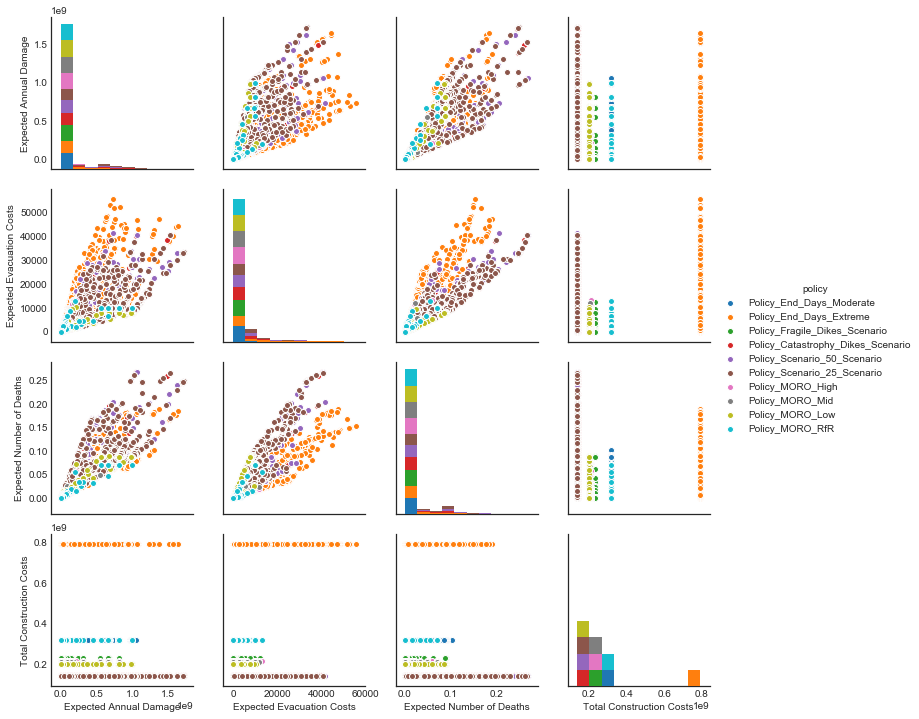

In [558]:
df_output['policy'] = df_experiment['policy']

sns.pairplot(df_output, hue='policy',  vars=df_output.columns.drop('policy'), )

plt.show()

In [570]:
def calculate_regret(data, best):
    return np.abs(best-data)

regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = df_experiment['policy']
    
    data = pd.DataFrame({outcome.name: df_output[outcome.name], 
                         "policy":df_experiment['policy'],
                         "scenario_id":df_experiment['scenario_id']})
    
    data = data.pivot(index='scenario_id', columns='policy')
    data.columns = data.columns.get_level_values(1)
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    regret[outcome.name] = regret
    max_regret[outcome.name] = outcome_regret.max()

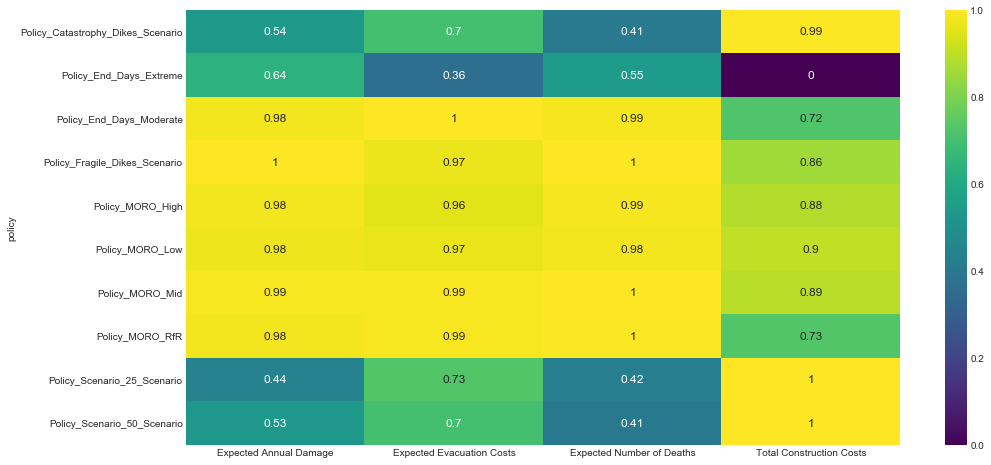

In [574]:
max_regret = pd.DataFrame(max_regret)
plt.figure(figsize = (16,8))
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True,annot_kws={"size": 12})

plt.show()

### 5.3 PRIM Iterative Discovery 

In [837]:
policy_robust_rfr = Policy("Policy_Robust_RfR", **levers_parameter(6,9,10,5,10,
                                                         0,0,0,1,0,
                                                         2))

policy_robust_dikes = Policy("Policy_Robust_Dikes", **levers_parameter(9,10,10,10,10,
                                                         0,0,0,0,0,
                                                         3))

policy_robust_cheap = Policy("Policy_Robust_Cheap", **levers_parameter(5,9,5,10,10,
                                                         0,0,0,0,0,
                                                         2))

In [838]:
# number scenarios
n_scenarios = 10000

start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_prim_2 = evaluator.perform_experiments(n_scenarios, policies = [policy_robust_rfr,
                                                                            policy_robust_dikes,
                                                                            policy_robust_cheap])
    
end = time.time()
print('Processing time :',(end - start)/60, 'Minutes')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10000 scenarios * 3 policies * 1 model(s) = 30000 experiments
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] 15000 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 21000 cases completed
[MainProcess/INFO] 24000 cases completed
[MainProcess/INFO] 27000 cases completed
[MainProcess/INFO] 30000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Processing time : 55.03150479793548 Minutes


In [839]:
experiments_prim_2, outcomes_prim_2 = results_prim_2
dfexperiment_prim_2 = pd.DataFrame(data=experiments_prim_2)
dfoutput_prim_2 = pd.DataFrame(data=outcomes_prim_2)
dfexperiment_prim_2.to_csv('dfexperiment_prim_2.csv', encoding='utf-8', index=False)
dfoutput_prim_2.to_csv('dfoutput_prim_2.csv', encoding='utf-8', index=False)

##### READ outcome of experiments

In [840]:
df_experiment_prim_2 = pd.read_csv('dfexperiment_prim_2.csv')
df_output_prim_2 = pd.read_csv('dfoutput_prim_2.csv')

In [841]:
select_policy_robust_rfr = (df_experiment_prim_2.policy == 'Policy_Robust_RfR')
select_policy_robust_dikes = (df_experiment_prim_2.policy == 'Policy_Robust_Dikes')
select_policy_robust_cheap = (df_experiment_prim_2.policy == 'Policy_Robust_Cheap')

In [879]:
print( "Percentage of deaths more than 0.001", ':', 
      len(df_output_prim_2[df_output_prim_2['Expected Number of Deaths'] > 0.001])*100 /len(
    df_output_prim_2['Expected Number of Deaths']),'%')

print("Maximum Deaths",':',df_output_prim_2['Expected Number of Deaths'].max())

print('Average of Deaths',':',df_output_prim_2['Expected Number of Deaths'].mean())

Percentage of deaths more than 0.001 : 16.27 %
Maximum Deaths : 0.23584584944
Average of Deaths : 0.002594250619573275


### 5.3.1 Prim in policies Policy_Robust_RfR

In [863]:
len(df_output_prim_2[select_policy_robust_rfr][df_output_prim_2['Expected Number of Deaths'] > 0])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


3185

In [870]:
df_output_prim_2[select_policy_robust_rfr]['Expected Number of Deaths'].mean()

0.0012832954648055543

In [843]:
# Select policy to do Prim
a_x_prim_2 = df_experiment_prim_2[select_policy_robust_rfr].drop(['scenario_id','policy','model'],axis=1).to_records(index=False)
a_y_prim_2= (df_output_prim_2[select_policy_robust_rfr]['Expected Number of Deaths'] > 0).astype(int).reset_index(drop=True)

In [844]:
prim_alg_prim_2 = prm.Prim(a_x_prim_2, a_y_prim_2, threshold=0.8 ,threshold_type=">")
box1_prim_2 = prim_alg_prim_2.find_box()

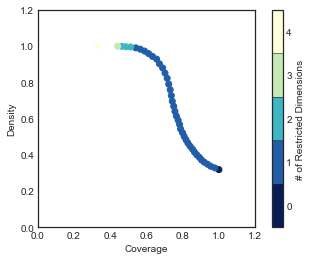

In [845]:
%matplotlib inline
# %matplotlib notebook
box1_prim_2.show_tradeoff()
plt.show()

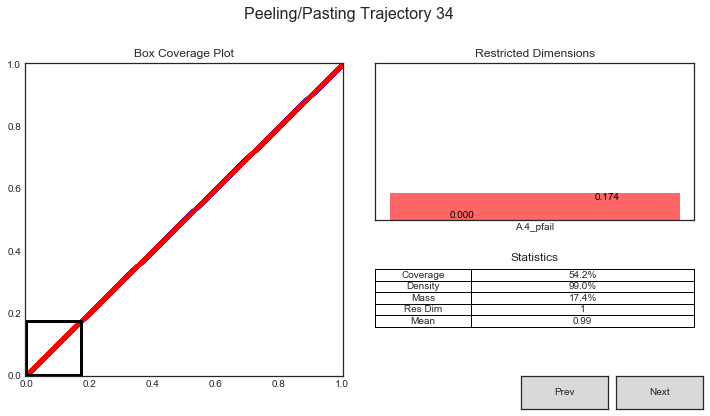

In [846]:
box_selection = 34
box1_prim_2.select(box_selection)
box1_prim_2.show_details()
plt.show()

### 5.3.2 Prim in policies Policy_Robust_Dikes

In [864]:
len(df_output_prim_2[select_policy_robust_dikes][df_output_prim_2['Expected Number of Deaths'] > 0])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


966

In [869]:
df_output_prim_2[select_policy_robust_dikes]['Expected Number of Deaths'].mean()

0.00014861046830625082

In [847]:
# Select policy to do Prim
b_x_prim_2 = df_experiment_prim_2[select_policy_robust_dikes].drop(['scenario_id','policy','model'],axis=1).to_records(index=False)
b_y_prim_2= (df_output_prim_2[select_policy_robust_dikes]['Expected Number of Deaths'] > 0).astype(int).reset_index(drop=True)

In [848]:
prim_alg_prim_2_b = prm.Prim(b_x_prim_2, b_y_prim_2, threshold=0.8 ,threshold_type=">")
box1_prim_2_b = prim_alg_prim_2_b.find_box()

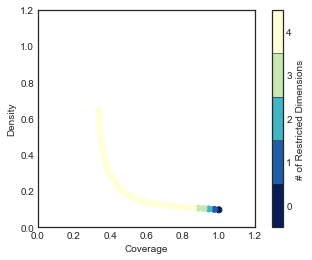

In [849]:
%matplotlib inline
# %matplotlib notebook
box1_prim_2_b.show_tradeoff()
plt.show()

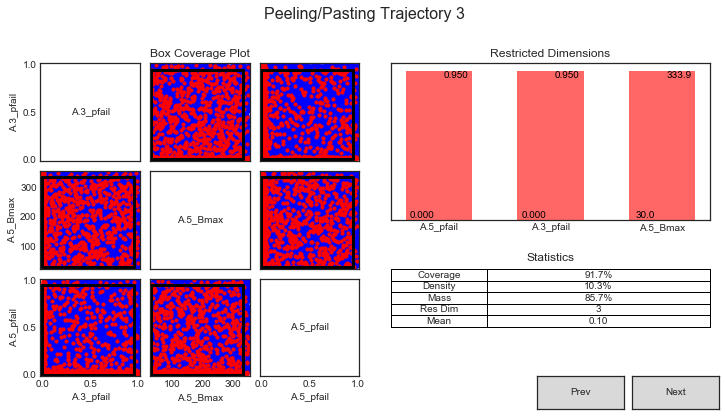

In [850]:
box_selection = 3
box1_prim_2_b.select(box_selection)
box1_prim_2_b.show_details()
plt.show()

### 5.3.2 Prim in policies Policy_Robust_Cheap

In [862]:
len(df_output_prim_2[select_policy_robust_cheap][df_output_prim_2['Expected Number of Deaths'] > 0])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


4981

In [868]:
df_output_prim_2[select_policy_robust_cheap]['Expected Number of Deaths'].mean()

0.006350845925607993

In [901]:
# Select policy to do Prim
c_x_prim_2 = df_experiment_prim_2[select_policy_robust_cheap].drop(['scenario_id','policy','model'],axis=1).to_records(index=False)
c_y_prim_2= (df_output_prim_2[select_policy_robust_cheap]['Expected Number of Deaths'] > 0).astype(int).reset_index(drop=True)

In [902]:
prim_alg_prim_2_c = prm.Prim(c_x_prim_2, c_y_prim_2, threshold=0.8 ,threshold_type=">")
box1_prim_2_c = prim_alg_prim_2_c.find_box()

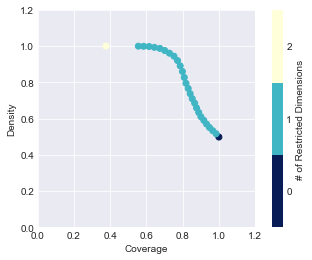

In [903]:
%matplotlib inline
# %matplotlib notebook
box1_prim_2_c.show_tradeoff()
plt.show()

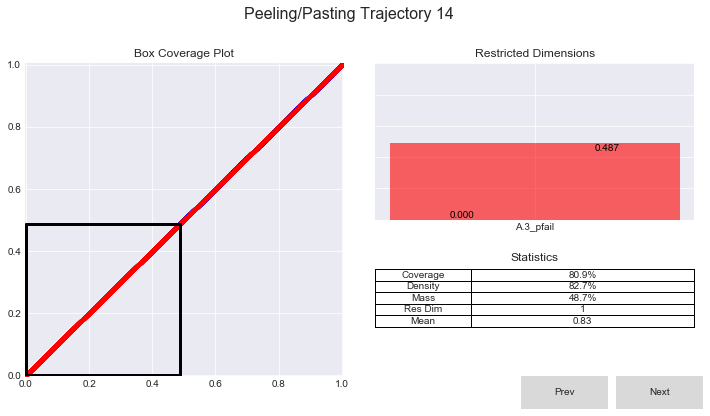

In [911]:
box_selection = 14
box1_prim_2_c.select(box_selection)
box1_prim_2_c.show_details()
plt.show()

### 5.3.3 Pairplot Overview of 3Sample Range of Policies Recommendation

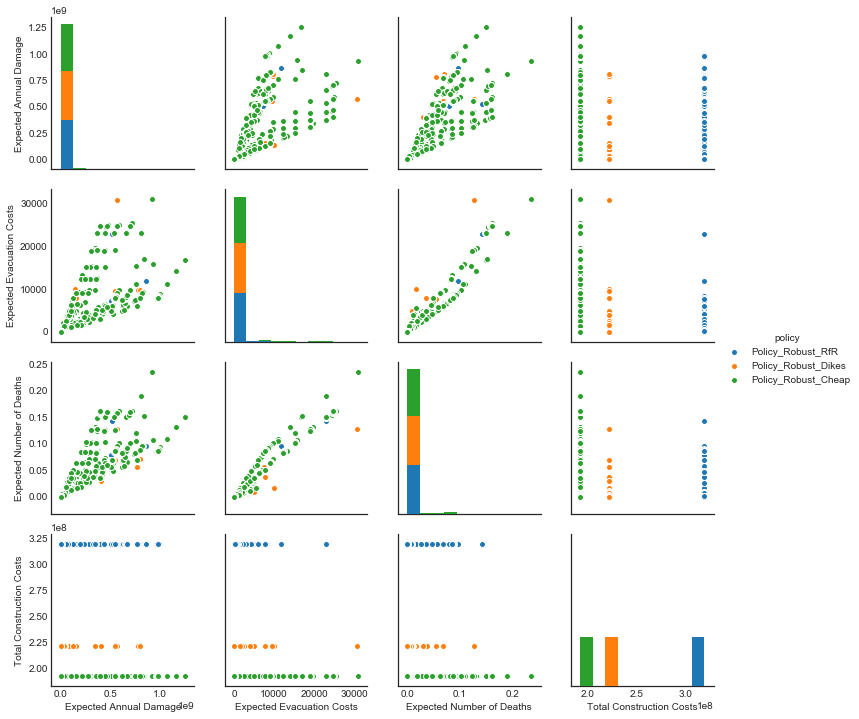

In [855]:
df_output_prim_2['policy'] = df_experiment_prim_2['policy']

sns.pairplot(df_output_prim_2, hue='policy',  vars=df_output_prim_2.columns.drop('policy'), )

plt.show()